<h1>Machine Learning for Exoplanet Observability</h1>
<h4>Drexel University - MEM T680 - Fall 2023</h4>
<h4>Author: Anupam Mishra</h4>

This report outlines my Final Project for MEM T680: Data Analysis and Machine Learning.
It discusses the steps taken to develop supervised and unsupervised machine learning models to help determine measures of observability for the atmospheres of confirmed exoplanets throughout the observable universe.

**Note:** All of the plots that are generated in this report have been saved under docs/plots in case they need to be accessed.

<h3>Background Information</h3>
Exoplanets are defined as any planet that orbits a star outside of the Solar System. To date, roughly 7000 exoplanets have been confirmed and many more are being discovered by the day through incredibly powerful space telescope such as the James Webb Space Telescope, TESS (Transiting Exoplanet Survey Satellite), Kepler, and more. The discovery and subsequent study of these exoplanets can teach astronomers much about the universe by allowing them to categorize these planets and learn their characteristics, going so far as to determine whether they may be sustainable to support life. There are countless planets to be discovered and countless observations to be made.

There are many methods of detecting exoplanets, but most are detected through Transit Events. These are events during which an exoplanet passes between its host star and the observer (Earth). This transit causes the light from the star to dim slightly, and this perturbation can be measured and used to determine various parameters about an exoplanet such as its size, gravitational force, distance to its star, orbital period, and more. 

Unfortunately, not all exoplanets are equally observable with today's technology, even with a tool such as transit events. Factors included in the data that will be discussed in this report can greatly impact how well an exoplanet's atmosphere can be observed, with this number varying significantly and in complex ways depending on the combination of parameters that define a given exoplanet. The machine learning models implemented in this project will aim to tackle that problem.

<h3>Dataset Selection</h3>

<p>The dataset used in this analysis contains information on confirmed exoplanets with various attributes, spanning across 18,428 different observations. Here are the key columns in the dataset:

<strong>
<ul>
<li>Planet Name (Planet_Name)</li>
<li>1.5 micron emission SNR (signal-to-noise ratio) relative to HD 209458 b (SNR_Emission_15_micron)</li>
<li>5 micron emission SNR relative to HD 209458 b (SNR_Emission_5_micron)</li>
<li>K-band Transmission SNR relative to HD 209458 b (SNR_Transmission_K_mag)</li>
<li>Planet radius (Rp) [Jupiter radii]</li>
<li>Planet mass (Mp) [Jupiter masses]</li>
<li>Dayside temperature (Tday) [K]</li>
<li>Planet equilibrium temperature (Teq) [K]</li>
<li>Planet surface gravity (log10g_p) [log(cm/s^2)]</li>
<li>Planet orbital period (Period) [days]</li>
<li>Planet transit duration (Transit_Duration) [hours]</li>
<li>K-band magnitude (K_mag) [mag]</li>
<li>Distance to planet host star (Distance) [parsecs]</li>
<li>Stellar effective temperature (Teff) [K]</li>
<li>Stellar surface gravity (log10g_s) [log(cm/s^2)]</li>
<li>Planet transit flag (Transit_Flag) - FALSE or TRUE</li>
<li>Planet source catalog name (Catalog_Name)</li>
</ul>
</strong>
</p>

<h3>Why is it useful?</h3>

<p>
The dataset is valuable for exoplanet scientists and researchers interested in atmospheric characterization through transmission and emission in the near- and mid-infrared wavebands. Key attributes such as emission SNR, transmission SNR, planet radius, mass, temperatures, and more, provide crucial information for determining the suitability of exoplanets for atmospheric studies.

With the recent launch of the James Webb Space Telescope (JWST), this dataset, particularly the provided signal-to-noise ratio (SNR) metrics, can aid in selecting optimal targets for atmospheric characterization. The dataset allows users to filter and sort exoplanets based on their expected signal strength, considering various observational parameters.

The inclusion of parameters like equilibrium temperature, surface gravity, and transit flags further enhances the dataset's utility in identifying potential candidates for detailed atmospheric studies. Overall, this dataset serves as a valuable resource for astronomers and researchers in the field of exoplanet studies, contributing to the selection of targets for JWST observations and advancing our understanding of exoplanetary atmospheres.
</p>

<h3>Import Libraries & Load Dataset</h3>
<p> First, we import the modules we need and load the dataset from the CSV file:</p>

In [38]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from dash import html
from dash.dependencies import Input, Output
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, accuracy_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import RobustScaler
from scipy.stats import zscore

# Load the dataset
df = pd.read_csv("search.csv")  # Load the dataset from search.csv



<h3>Adding Atmospheric Height</h3>
<p>A new column, 'Atmospheric_Height', is added to the dataset. This column represents the atmospheric height and is calculated using an established formula:</p>

In [39]:
# define the atmospheric height H based on existing formulas

df['H'] = 1000*8.3144598*df['Teq']/2.3/df['log10g_p']

<h2>Initial Data Visualization</h2>

To get a sense of what the raw dataset looks like, we can create some visualizations to interpret its nature and characteristics.

<h3>Plot 0: Missing Data Heatmap (Before Preprocessing)</h3>

<p>This data is vast and encompasses many recently-found exoplanets. For this reason, there is missing data within the dataset that must be accounted for to prevent it from negatively affecting a training model. To identify categories with large amounts of missing data, we can generate a heatmap as follows:</p>

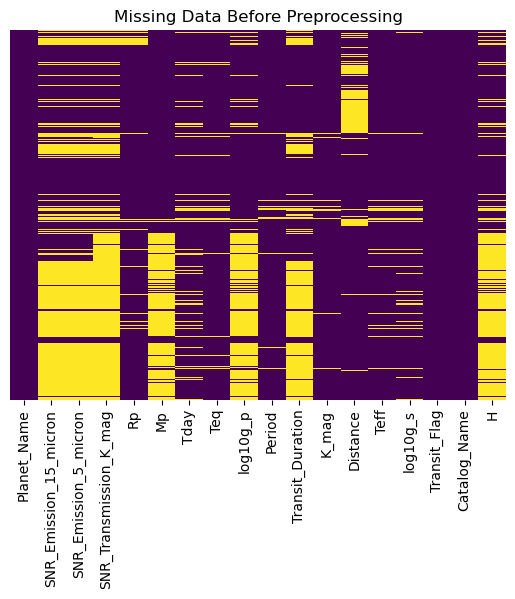

In [40]:
# Identify missing values
missing_values = df.isnull()

# Develop heatmap to visualize missing values
# Plot 0: Heatmap Showing Missing Values in Categories (Unprocessed/Raw Data)
heatmap = sns.heatmap(data = missing_values, yticklabels=False, cbar=False, cmap='viridis') # Heatmap format
heatmap.set_title('Missing Data Before Preprocessing') # Heatmap title
plt.show() # Display heatmap



<h3></h3>

<h3>Plot 1: Scatter plot of Planet Mass vs. 5 Micron Emission SNR with K mag Transmission SNR Colormap</h3>

The below scatterplot plots Planet Mass vs. 5 Micron Emission SNR with K mag Transmission SNR Colormap. The size of each data point represents the exoplanet's 1.5 Micron Emission SNR.

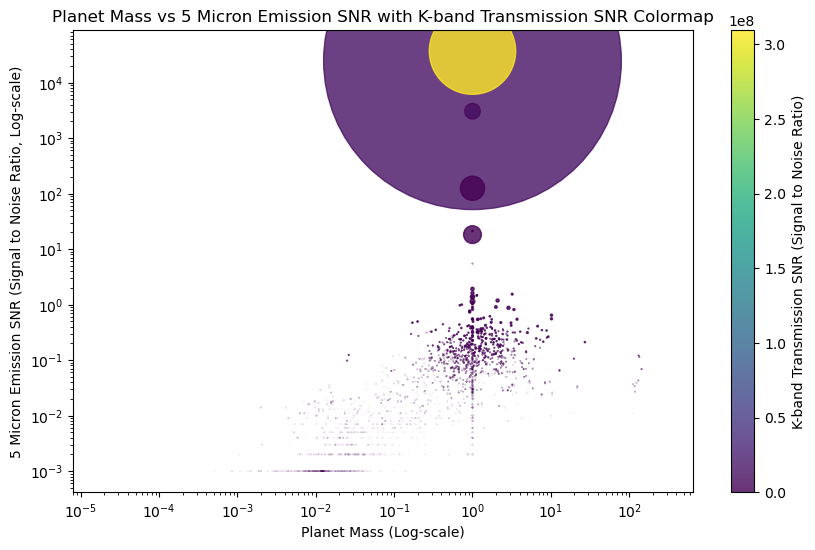

In [41]:
# Static Visualizations

# Plot 1: Scatter plot of Planet Mass vs. 5 Micron Emission SNR
plt.figure(figsize=(10, 6))

# Scatter plot with colormap and size based on Transit Duration
plt.scatter(df['Mp'], df['SNR_Emission_5_micron'], c=df['SNR_Transmission_K_mag'], cmap='viridis', s=df['SNR_Emission_15_micron'], alpha=0.8)  
plt.xlabel('Planet Mass (Log-scale)')  # X label
plt.ylabel('5 Micron Emission SNR (Signal to Noise Ratio, Log-scale)')  # Y label
plt.xscale('log')  # Set logarithmic scale for X-axis
plt.yscale('log')  # Set logarithmic scale for Y-axis
plt.title('Planet Mass vs 5 Micron Emission SNR with K-band Transmission SNR Colormap')  # Plot 1 Title
plt.colorbar(label='K-band Transmission SNR (Signal to Noise Ratio)')  # Set colorbar
plt.show()


The scatterplot shown obvious outliers that must be dealt with during preprocessing. There is a noticeable positive correlation between the Planet Mass and the SNR values.

<h3>Plot 2: Scatterplot of Planet Radius vs. Planet Mass with 1.5 Micron Emission SNR Colormap</h3>

The below scatterplot plots Planet Radius vs. Planet Mass with 1.5 Micron Emission SNR Colormap. The size of each data point represents the exoplanet's Transit Duration.

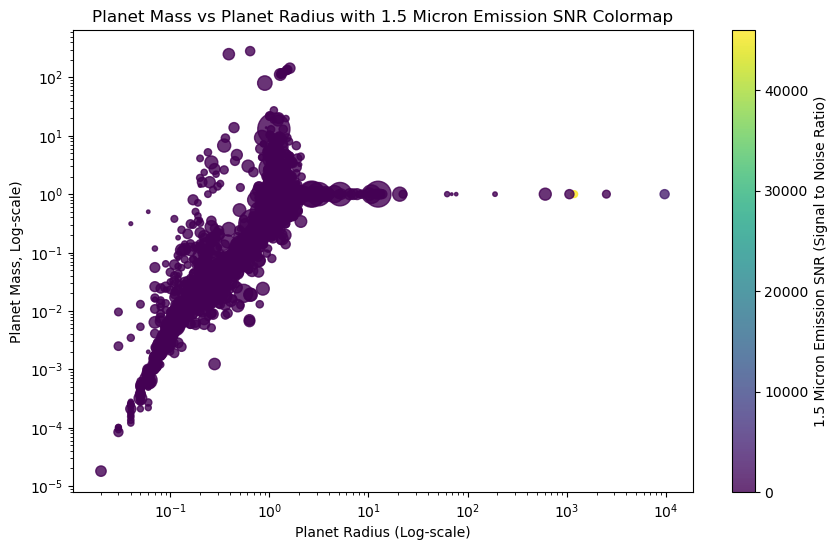

In [42]:
# Plot 2: Scatter plot of Planet Radius vs. Planet Mass
plt.figure(figsize=(10, 6))

# Scatter plot with colormap and size based on Transit Duration
plt.scatter(df['Rp'], df['Mp'], c=df['SNR_Emission_15_micron'], cmap='viridis', s=df['Transit_Duration']*10, alpha=0.8)  
plt.xlabel('Planet Radius (Log-scale)')  # X label
plt.ylabel('Planet Mass, Log-scale)')  # Y label
plt.xscale('log')  # Set logarithmic scale for X-axis
plt.yscale('log')  # Set logarithmic scale for Y-axis
plt.title('Planet Mass vs Planet Radius with 1.5 Micron Emission SNR Colormap')  # Plot 2 Title
plt.colorbar(label='1.5 Micron Emission SNR (Signal to Noise Ratio)')  # Set colorbar
plt.show()

There is an evident correlation between Planet Radius, Planet Mass, and Transit Duration. However, this plot isn't telling us much about the SNR values in the colormap since it hasn't been normalized and there are some outliers present.

<h3>Plot 3: Pie Chart of Greatest SNR Value</h3>

A pie chart plotting the largest SNR value for all of the data points can tell us about which of them has the greatest chance of having a relatively high value. This can provide insights into which of the SNR values should be used for machine learning targeting.

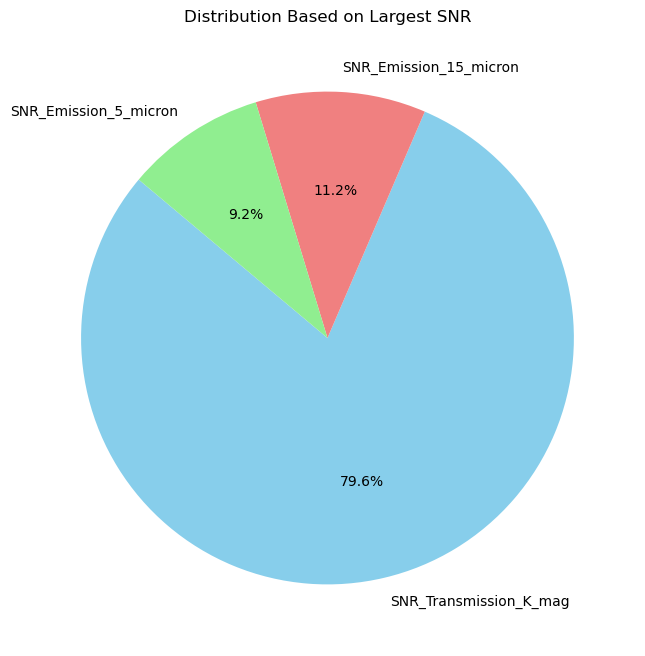

In [43]:
# Plot 3: Pie Chart of Greatest SNR Values between the given 3

# Identify the column with the largest value for each row
df['Largest_SNR'] = df[['SNR_Emission_15_micron', 'SNR_Emission_5_micron', 'SNR_Transmission_K_mag']].idxmax(axis=1)  # Find the column with the largest SNR value for each row

# Count the occurrences of each category
counts = df['Largest_SNR'].value_counts()  # Count the occurrences of each category

# Create a static pie chart
plt.figure(figsize=(8, 8))
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'lightcoral', 'lightgreen'])  # Pie chart with percentages and colors
plt.title('Distribution Based on Largest SNR')  # Pie chart title
plt.show()


<h3>Plot 4: Pair Plots</h3>

We can build pair plots to graph different data features against each other within the raw data.

/Users/anupammishra/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


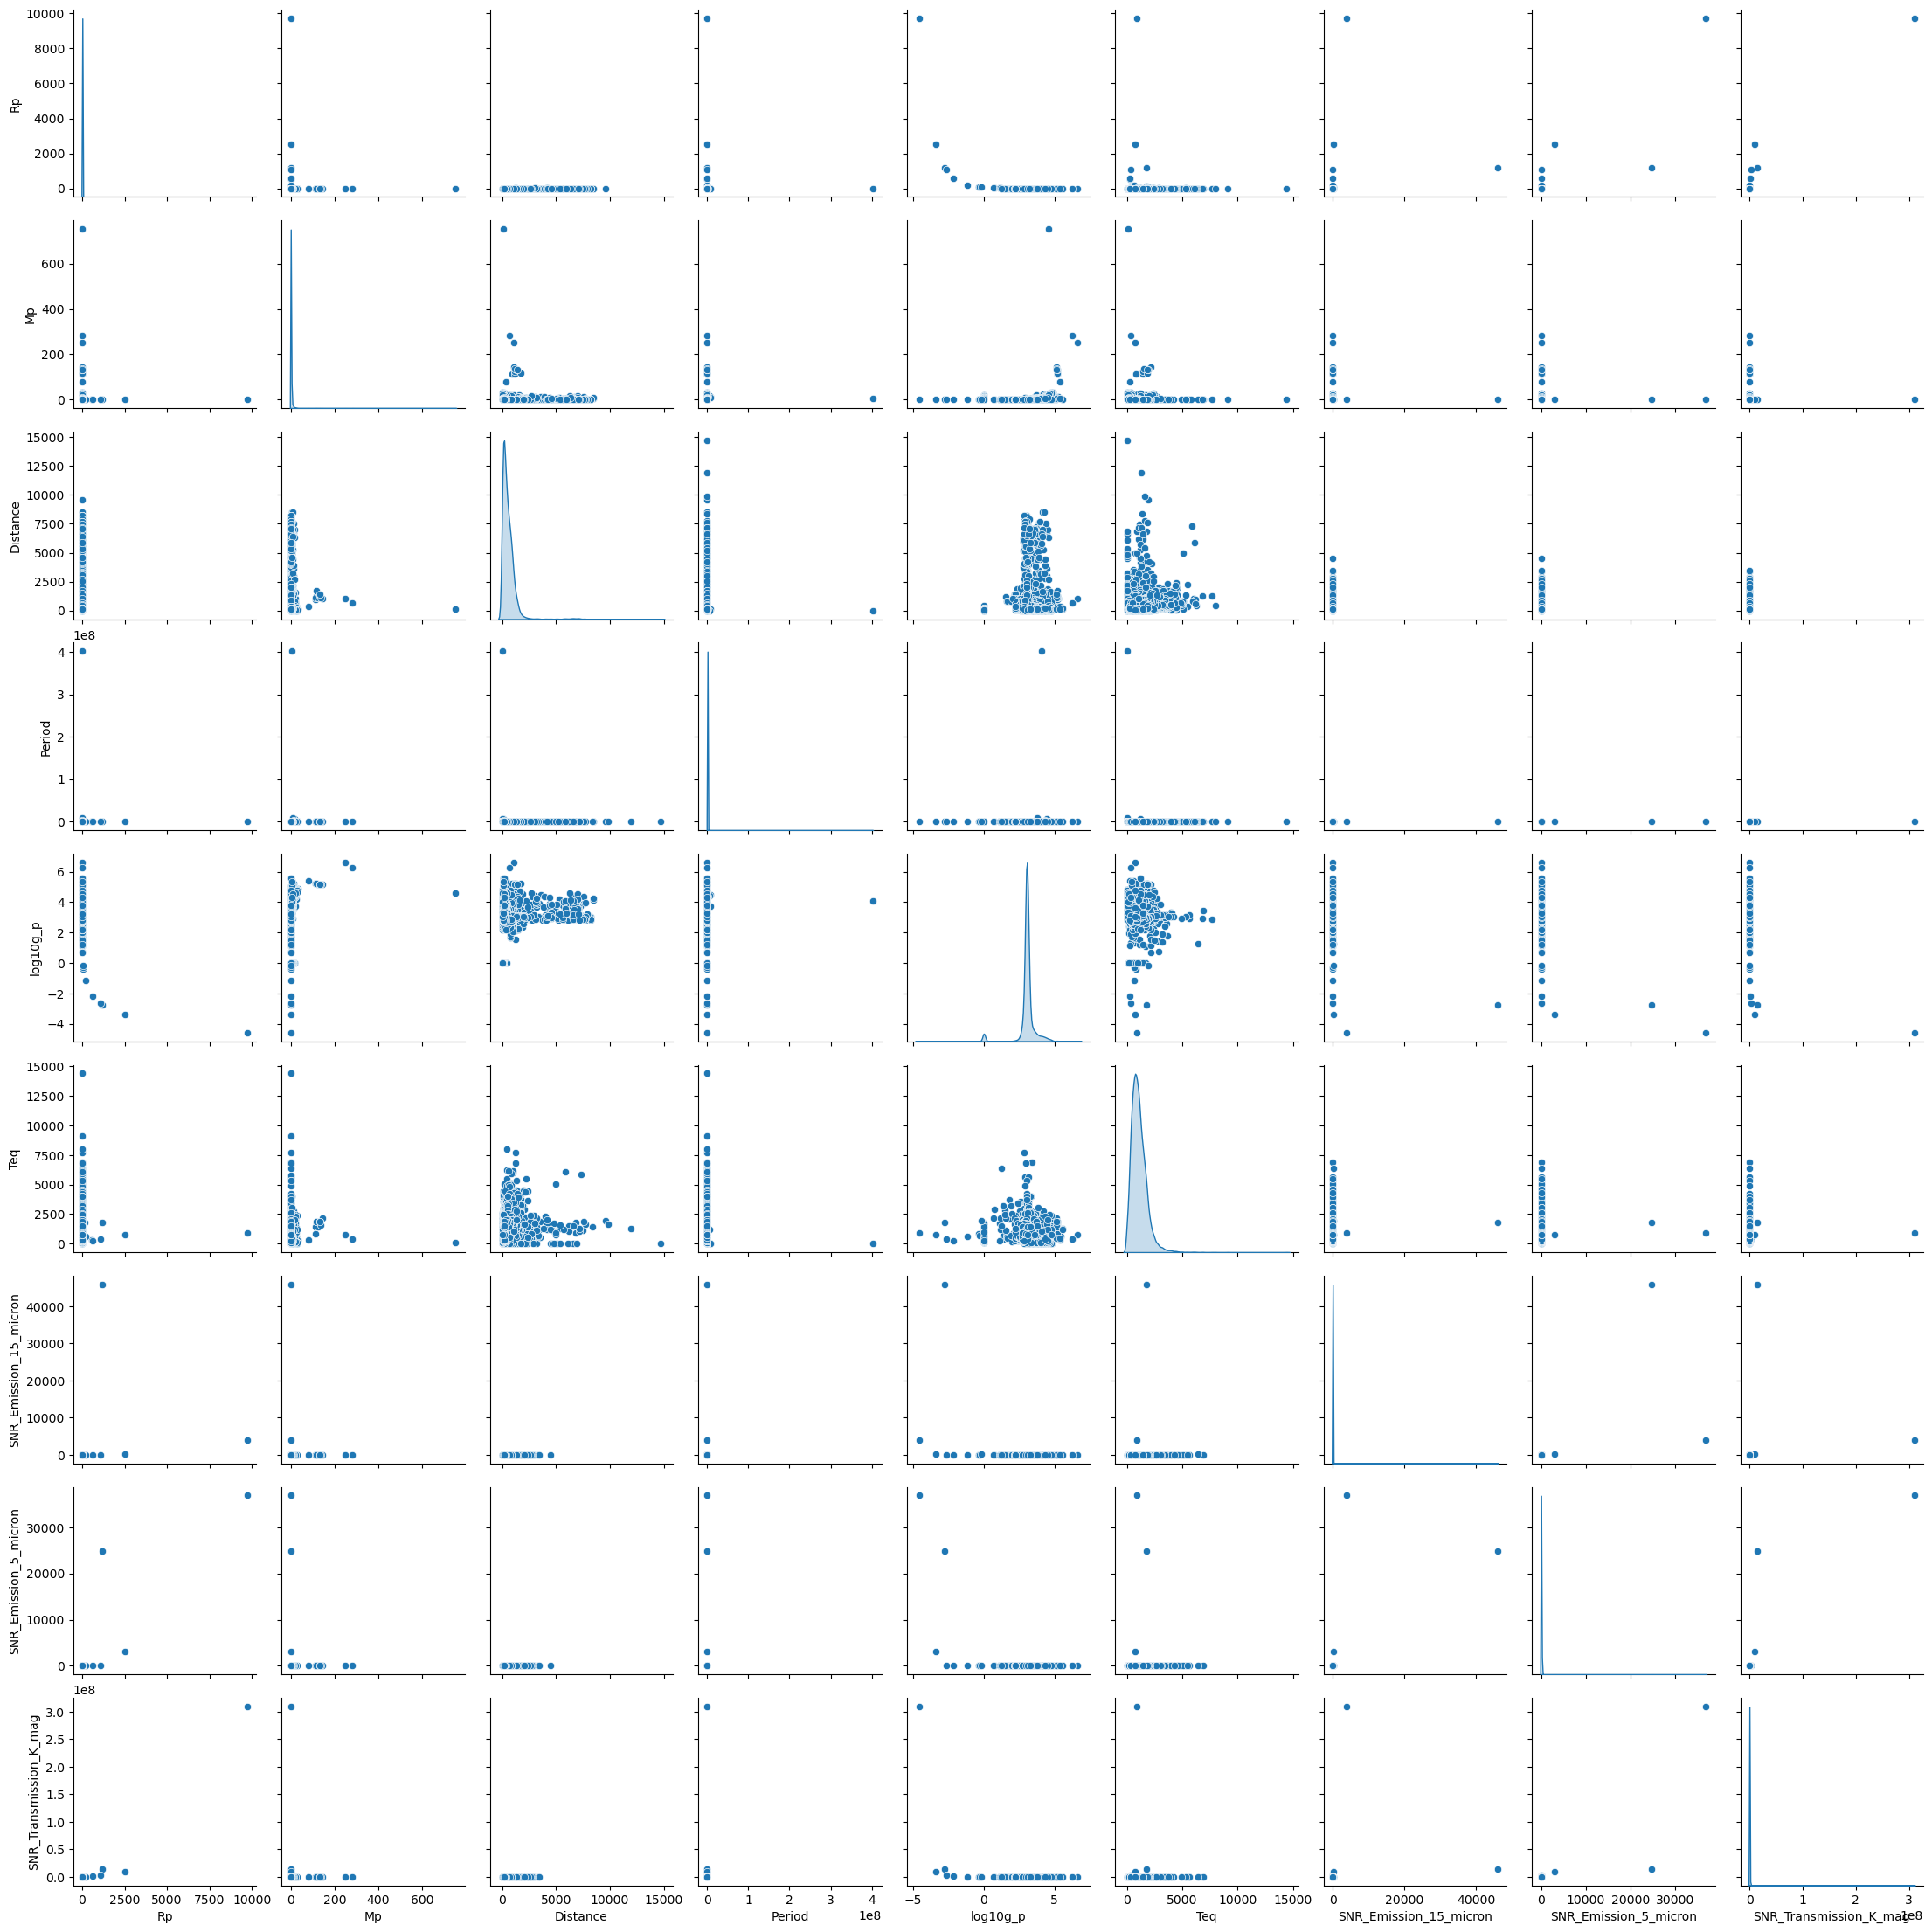

In [44]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# Plot 4: Pair Plots
# Assuming 'df' is your DataFrame with relevant columns
# Include the features and target variables in the pair plot
columns_to_plot = ['Rp', 'Mp', 'Distance', 'Period', 'log10g_p', 'Teq','SNR_Emission_15_micron', 'SNR_Emission_5_micron', 'SNR_Transmission_K_mag']

# Create a subset of the DataFrame with the selected columns
df_subset = df[columns_to_plot]

# Plotting pair plot
sns.pairplot(df_subset, diag_kind='kde', markers='o')
plt.show()


Evidently, the data is not presented very well. This is due to there having been no preprocessing or normalization done to scale the data and make it easier to understand. That will be the next step.

<h2>Interactive Scatterplot</h2>

<p>An interactive scatterplot is created using Dash to provide a user interface to change the plot. The x and y axes are fixed as the planet radius and planet mass, respectfully, while the colormap variable can be selected from a list of all available categories within the dataset. The size of the points represents 'Transit Duration' for each exoplanet. This scatterplot can be found in src/exoplanets/hw4-plots.py</p>

<h2>Preprocessing of Data</h2>
<p>With a large amount missing from a few categories, notable the SNR values, Planet Mass, Planet Gravity, Transit Duration, and Atmospheric Height, we preprocess the data to create a cleaner, usable dataset without discrepancies and bias.</p>

<h4>Data Cleaning</h4>
<p>The data is cleaned by simply removing observation data with missing values for any given features. Doing this ensures that there are no issues in training a machine learning model since all data being used will have all relevant features included.<p>

In [45]:
# Preprocessing - remove rows with missing values
df.dropna(inplace=True)

<h4>Percentile Scaling (Median-MAD Scaling) Normalization</h4>
<p>Normalization is performed to the dataset so that it is better suited for machine learning, and isn't affected by large outliers. To effectively scale the data without having significant effect from outliers, we can use Min-Max Scaling. This form of normalization transforms features to a specific range, usually [0,1]. Min-Max Scaling can be described by this formula:
<p>
<p>X<sub>scaled</sub> = (X - X<sub>min</sub>) / (X<sub>max</sub> - X<sub>min</sub>) </p>



<b>Steps to perform Min-Max Scaling</b>
<strong>
<ol>
<li>Define columns of the dataset</li>
<li>Apply MinMax Scaling using MinMaxScaler() from Scikit Learn</li>
<li>Remove outliers based on scaled values with threshold of 0.95</li>
</ol>




In [46]:
# Import the MinMaxScaler from scikit-learn
from sklearn.preprocessing import MinMaxScaler

# Assuming X is your dataset
numeric_columns = df.select_dtypes(include=np.number).columns

# Create an instance of the MinMaxScaler
scaler = MinMaxScaler()

# Apply MinMax scaling to the numeric columns in the DataFrame
df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

# Define a threshold for outlier removal (adjust as needed)
threshold = 0.95

# Create a boolean mask identifying rows with values above the threshold for all numeric columns
outlier_mask = (df[numeric_columns] >= threshold).all(axis=1)

# Remove rows identified by the outlier mask (keeping rows where at least one value is below the threshold)
df = df[~outlier_mask]


<h4>Other Types of Normalization (Attempted)</h4> 

<h5>Z-score Normalization</h5>
<p>Since there are some pretty big outliers in the exoplanet data, I had attempted a Z-score normalization. The z-score of a data point measures how many standard deviations away it is away from the mean of the feature. To get rid of major outliers while still preserving most of the data, the Z-score normalization was applied with a threshold value of 3. This meant that data within 3 standard deviations from the mean of each feature was kept, while those data points outside of this threshold were dropped. Unfortunately, too much of the data was rejected and this affected K-means clustering later on, so I decided not to go with it.</p>

<h5>Robust Scaling Normalization</h5>
<p>I also tried to perform Robust Scaling, based on the median and interquartile range. This uses the median and IQR for scaling rather than the median and standard deviation, making it more robust when dealing with extreme values. It is denoted by the following formula:</p>

<p>X<sub>scaled</sub> = (X - Median(X)) / IQR(X) </p>

<p>Unfortunately, this normalization method was not suitable for visualizing the results of the machine learning methods implemented, and so it was rejected.</p>

<h2>Visualization of Preprocessed Data</h2>

<h3>Plot 1: Scatter plot of Planet Mass vs. 5 Micron Emission SNR with K mag Transmission SNR Colormap</h3>
<p>To visualize the relationship between the mass of exoplanets, the emission signal-to-noise ratio (SNR) at a frequency of 5 microns, and K-band transmission SNR, a scatterplot with a colormap is plotted. This can provide important information on how a planet's mass affects its likeliness to be a candidate for atmospheric studies based on how strong of a signal it can produce during transit relative to the noise received from its stellar flux and surroundings. The colors of the datapoints represent the valye of the K-band transmission SNR, while the size represents the 1.5 Micron Emission SNR.</p>

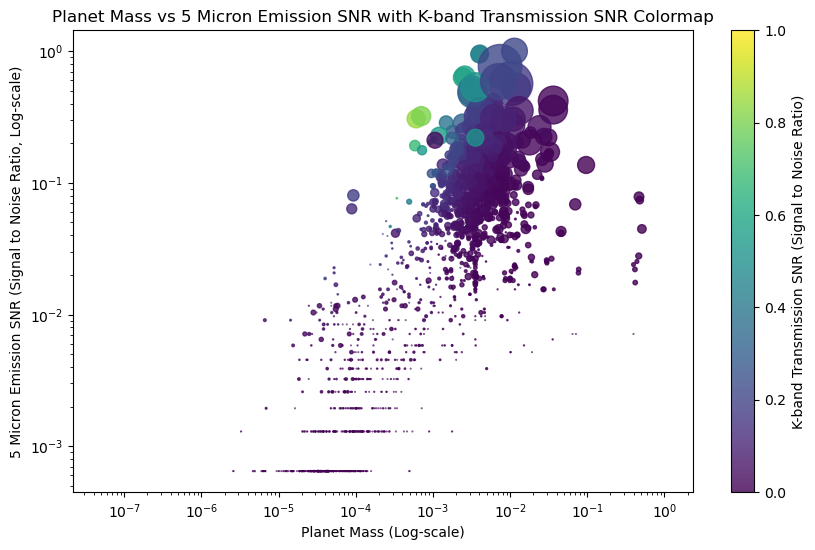

In [47]:
# Static Visualizations

# Plot 1: Scatter plot of Planet Mass vs. 5 Micron Emission SNR
plt.figure(figsize=(10, 6))

# Scatter plot with colormap and size based on Transit Duration
plt.scatter(df['Mp'], df['SNR_Emission_5_micron'], c=df['SNR_Transmission_K_mag'], cmap='viridis', s=df['SNR_Emission_15_micron']*1000, alpha=0.8)  
plt.xlabel('Planet Mass (Log-scale)')  # X label
plt.ylabel('5 Micron Emission SNR (Signal to Noise Ratio, Log-scale)')  # Y label
plt.xscale('log')  # Set logarithmic scale for X-axis
plt.yscale('log')  # Set logarithmic scale for Y-axis
plt.title('Planet Mass vs 5 Micron Emission SNR with K-band Transmission SNR Colormap')  # Plot 1 Title
plt.colorbar(label='K-band Transmission SNR (Signal to Noise Ratio)')  # Set colorbar
plt.show()


This scatterplot is much better than the one generated before preprocessing since major outliers have been removed and the data has been effectively normalized. You can see a correlation between Planet Mass and the 5 Micron and K-band SNR values in this plot. The colormap is far more distinct than it was before preprocessing.

<h3>Plot 2: Scatterplot of Planet Radius vs. Planet Mass with 1.5 Micron Emission SNR Colormap</h3>

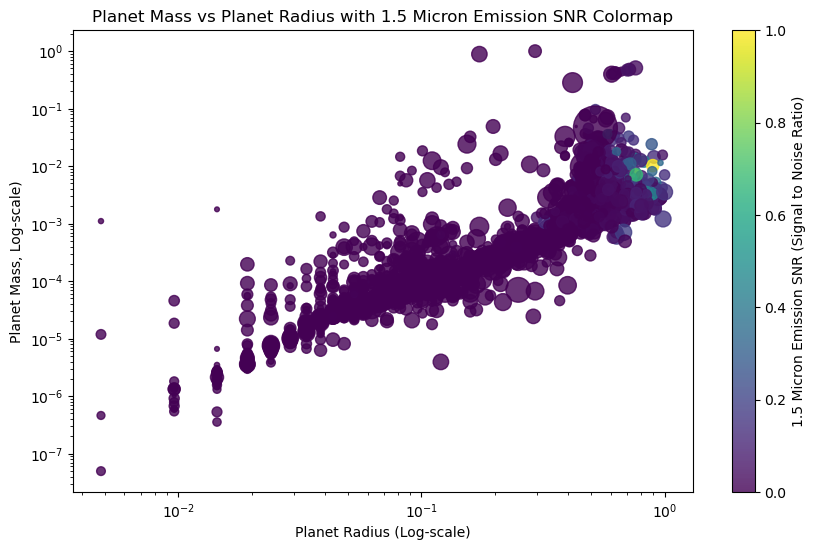

In [48]:
# Plot 2: Scatter plot of Planet Radius vs. Planet Mass
plt.figure(figsize=(10, 6))

# Scatter plot with colormap and size based on Transit Duration
plt.scatter(df['Rp'], df['Mp'], c=df['SNR_Emission_15_micron'], cmap='viridis', s=df['Transit_Duration']*1000, alpha=0.8)  
plt.xlabel('Planet Radius (Log-scale)')  # X label
plt.ylabel('Planet Mass, Log-scale)')  # Y label
plt.xscale('log')  # Set logarithmic scale for X-axis
plt.yscale('log')  # Set logarithmic scale for Y-axis
plt.title('Planet Mass vs Planet Radius with 1.5 Micron Emission SNR Colormap')  # Plot 1 Title
plt.colorbar(label='1.5 Micron Emission SNR (Signal to Noise Ratio)')  # Set colorbar
plt.show()

This looks a lot better than the previous plot (before preprocessing). The colormap is now visible and there is a clear correlation between the variables, absent of any major outliers. There is also a positive correlation between SNR and Transit Duration.

<h3>Plot 3: Pie Chart of Greatest SNR Value</h3>
<p>A pie chart is plotted again to identify which out of the three SNR values (1.5 micron Emission, 5 micron Emission, and K-band Transmission) is greatest for each exoplanet after preprocessing. This can provide insight into which categories are most likely to produce favorable results in identifying exoplanets with observable atmospheres.</p>

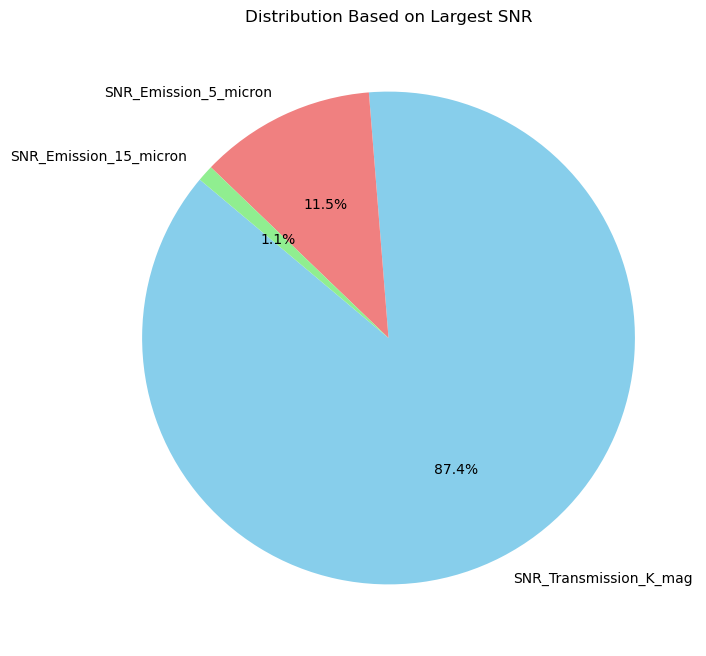

In [49]:
# Plot 3: Pie Chart of Greatest SNR Values between the given 3

# Identify the column with the largest value for each row
df['Largest_SNR'] = df[['SNR_Emission_15_micron', 'SNR_Emission_5_micron', 'SNR_Transmission_K_mag']].idxmax(axis=1)  # Find the column with the largest SNR value for each row

# Count the occurrences of each category
counts = df['Largest_SNR'].value_counts()  # Count the occurrences of each category

# Create a static pie chart
plt.figure(figsize=(8, 8))
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'lightcoral', 'lightgreen'])  # Pie chart with percentages and colors
plt.title('Distribution Based on Largest SNR')  # Pie chart title
plt.show()


This pie chart shows that the proportion of data values in which SNR 15 is the greatest of the three signal-to-noise ratios has gone down dramatically after preprocessing, with Kband Transmission SNR being the most commonly greatest for the vast majority of data. 

<h3>Plot 4: Pair Plots</h3>

<p>Pair plots are generated again to visualize the interrelatedness of the features within the dataset after preprocessing and understand what trends and patterns a machine learning model might pick up on amongst them. 

/Users/anupammishra/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


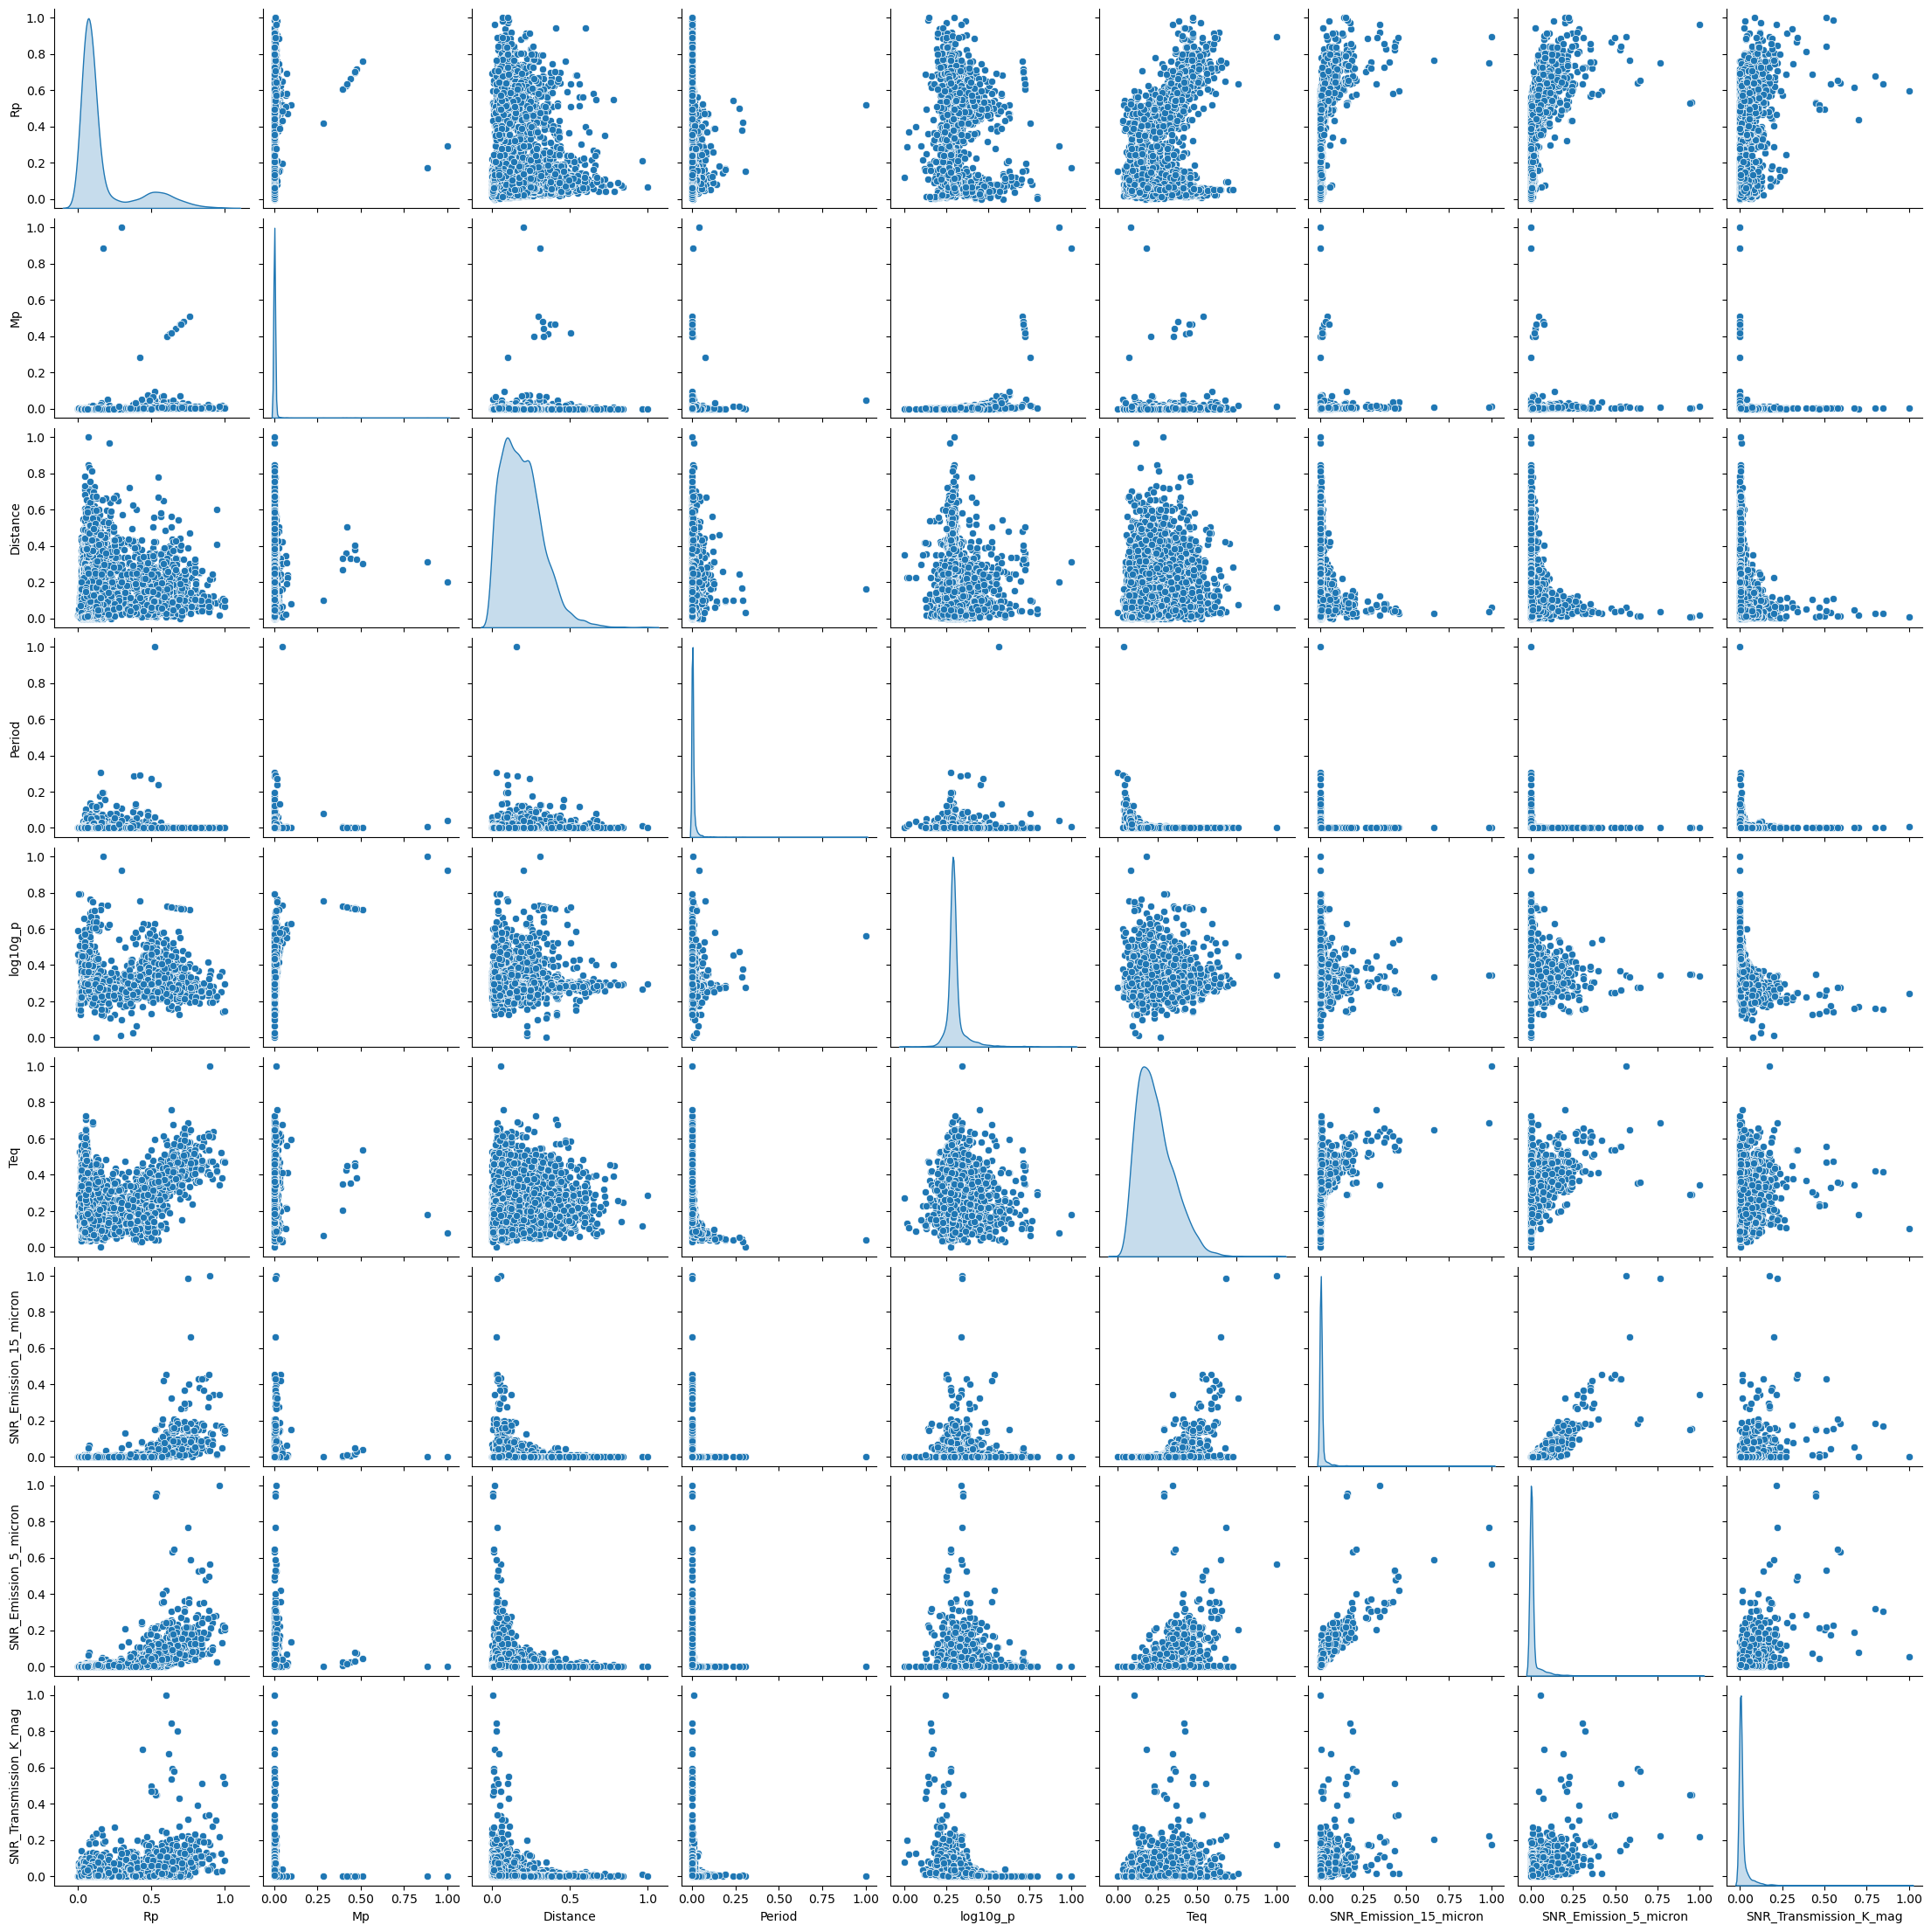

In [50]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# Plot 4: Pair Plots
# Assuming 'df' is your DataFrame with relevant columns
# Include the features and target variables in the pair plot
columns_to_plot = ['Rp', 'Mp', 'Distance', 'Period', 'log10g_p', 'Teq','SNR_Emission_15_micron', 'SNR_Emission_5_micron', 'SNR_Transmission_K_mag']

# Create a subset of the DataFrame with the selected columns
df_subset = df[columns_to_plot]

# Plotting pair plot
sns.pairplot(df_subset, diag_kind='kde', markers='o')
plt.show()


The pair plots are much cleaner now after normalization! There is a clear non-linear relationship betweeen some of the features, particularly Planet Radius (Rp), Distance, and the SNR values.



<h2>Machine Learning Challenge Description</h2>

The goal of this project is <b>to train machine learning models to determine and rank the relative observability of an exoplanet’s atmosphere for future studies based on its measured properties.</b> In the context of future astronomical studies, the focus is on understanding and predicting the degree to which an exoplanet's atmosphere can be observed. This predictive capability is derived from leveraging the measured properties of exoplanets, encompassing fundamental features such as size, mass, surface temperature, and other key characteristics.

Essentially, this challenge seeks to answer questions such as: How do the size, mass, and temperature of an exoplanet influence the observability of its atmosphere? Can we identify specific features that are more indicative of observable atmospheres? Through the lens of machine learning, the goal is to distill meaningful information from the data, enabling the creation of models that can not only predict observability but also rank exoplanets in terms of their atmospheric visibility for prospective studies. This kind of study can work towards laying the groundwork for future endeavors in the exploration and studying of exoplanetary atmospheres.

This machine learning problem is challenging due to the multidimensional nature of the dataset, the need for effective feature selection and scaling, potential class imbalances, and the application of both supervised and unsupervised learning techniques.
<ul>
<li>Data Complexity: The features I use for predictions, such as exoplanet radius, mass, gravity, and distance all contribute to the data's complexity. Some features have nonlinear relationships with the Emission SNR values, which can pose challenges in uncovering trends within the data to train a model.</li>
<li>Feature Selection: The features I select to train the machine learning models can heavily impact the model's performance. Scaling and normalization can help to tackle this, but features and their interrelationships must be closely analyzed before a model is trained.</li>

<li>The Curse of Dimensionality: Dimensionality can pose issues by making data sparse and difficult to use for training purposes. Since there are several features in my data, dimensionality may create problems in its implementation within machie learning models. Dimensionality reduction methods such as Principal Component Analysis (PCA) will need to be explored for this reason.</li>
</ul>


<h2>Supervised Learning</h2>
Supervised learning methods were employed to train a model to map from various exoplanet parameters presented in the dataset to SNR values so that it can predict these values for new, unseen data and draw conclusions on the atmosphere observability of new exoplanets.



<h3>Random Forest Regression</h3>


Random Forest Regression, often referred to as Random Forest Regressor, is a machine learning algorithm that belongs to the ensemble learning family. Specifically, it is an extension of the Random Forest algorithm applied to regression problems. Random Forest Regression is used for predicting a continuous variable (regression), as opposed to classification problems where the goal is to predict a categorical label. This is the first supervised learning method I attempted due to its ability to handle outliers and noise in a dataset and perform highly accurate predictions for non-linear data.

In implementing Random Forest, a pipeline is established which takes the preprocessed data and

1. Performs a Test-Train Split
2. Standardizes the features using StandardScaler()
3. Performs Hyperparameter Tuning using GridSearchCV

Hyperparameters considered (& best parameters):
- `n_estimators`: number of trees in the forest (100)
- `max_depth`: maximum depth of the tree (None)
- `min_samples_split`: minimum number of samples needed to split an internal node (5)
- `min_samples_leaf`: minimum number of samples needed to be at a leaf node (2)
    
4. Evaluates & Visualizes



Best Parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Mean Squared Error (Regression): 0.00034446655413966214


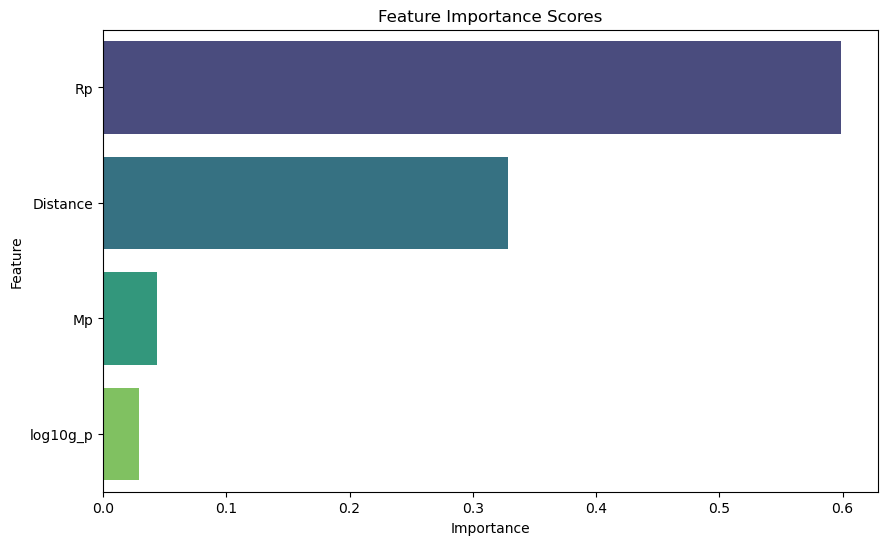

/Users/anupammishra/anaconda3/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/var/folders/1q/t149zr2d73977f02zdnrf1x00000gn/T/ipykernel_23911/1522714410.py:76: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=df, x='Rp', y='SNR_Emission_15_micron', palette='viridis')
/var/folders/1q/t149zr2d73977f02zdnrf1x00000gn/T/ipykernel_23911/1522714410.py:82: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=X_test_regression['Rp'], y=df['Predicted_SNR_Emission_15_micron'], palette='viridis')


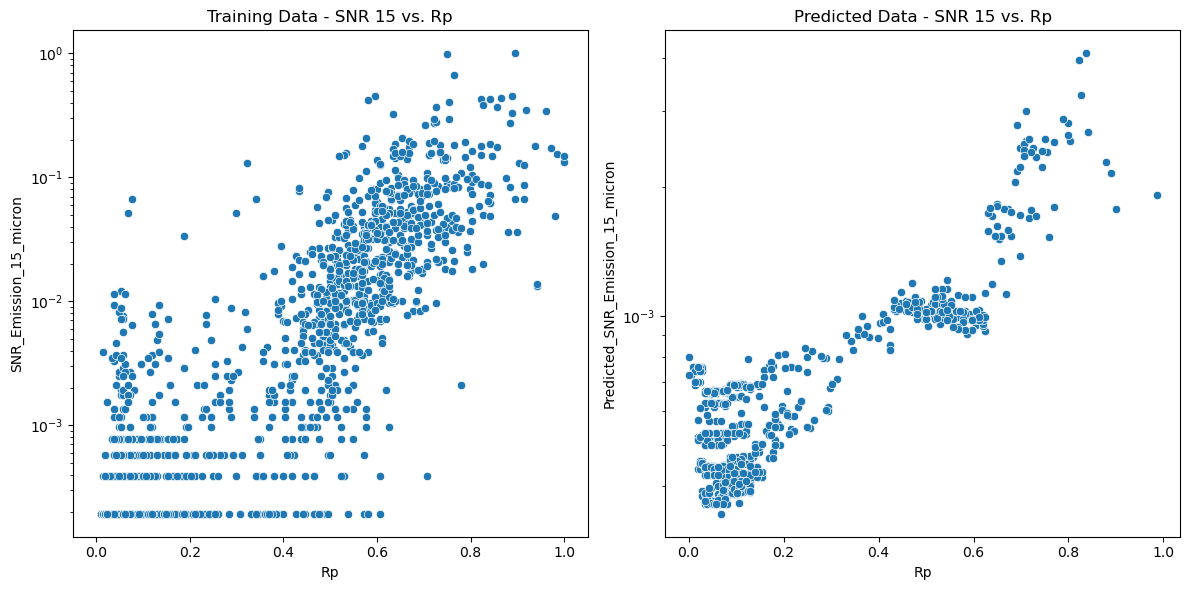

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# Features (X) and Target (y) for SNR prediction
X_regression = df[['Rp', 'Mp', 'Distance', 'log10g_p']]  # Add other features as needed
y_regression = df[['SNR_Emission_15_micron', 'SNR_Emission_5_micron']]

# Split the data into training and testing sets
X_train_regression, X_test_regression, y_train_regression, y_test_regression = train_test_split(
    X_regression, y_regression, test_size=0.2, random_state=42
)

# Standardize the features
scaler = StandardScaler()
X_train_regression_scaled = scaler.fit_transform(X_train_regression)
X_test_regression_scaled = scaler.transform(X_test_regression)

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the Random Forest Regressor
regressor = RandomForestRegressor(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(regressor, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the model with the best parameters
grid_search.fit(X_train_regression_scaled, y_train_regression)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Predict SNR values on the test set using the best model
best_regressor = grid_search.best_estimator_
y_pred_regression = best_regressor.predict(X_test_regression_scaled)

# Evaluate the regression model
mse_regression = mean_squared_error(y_test_regression, y_pred_regression)
print(f'Mean Squared Error (Regression): {mse_regression}')

# Get feature importance scores
feature_importances = best_regressor.feature_importances_

# Create a DataFrame with feature names and their importance scores
feature_importance_df = pd.DataFrame({'Feature': X_regression.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importance scores
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Feature Importance Scores')
plt.show()

# Predict SNR values for the entire dataset
df['Predicted_SNR_Emission_15_micron'], df['Predicted_SNR_Emission_5_micron'] = best_regressor.predict(X_regression).T

# Plot training and predicted SNR 15 values against Rp
plt.figure(figsize=(12, 6))

# Training Data - SNR 15 vs. Rp
plt.subplot(1, 2, 1)
sns.scatterplot(data=df, x='Rp', y='SNR_Emission_15_micron', palette='viridis')
plt.yscale('log')
plt.title('Training Data - SNR 15 vs. Rp') # scatterplot title

# Predicted Data - SNR 15 vs. Rp
plt.subplot(1, 2, 2)
sns.scatterplot(x=X_test_regression['Rp'], y=df['Predicted_SNR_Emission_15_micron'], palette='viridis')
plt.yscale('log') # assign log scale to y-axis
plt.title('Predicted Data - SNR 15 vs. Rp') # scatterplot title

plt.tight_layout()
plt.show()

<h4>Results of Random Forest Regression</h4>
The Mean-Squared Error for Random Forest is 0.00034446655413966214.
Therefore, this method does a good job of mapping SNR values from the given features.

The Feature Importance Scores plot above reflects the importance of the included features within the Random Forest Regression. Planet Radius and Distance seem to be the most important to the regression model, with Planet Mass and Planet Gravity being less important. This reflects how the dimensionality of the model could be reduced, by excluding the less important features.

The second plot compares the Training Data and Predicted Data from the Random Forest model. There is an evident similarity between both plots, as both follow positive trends. The model might however be facing an issue of overfitting and might not provide as accurate mapping when provided other unseen data.

<h3>Gradient-Boosting Regression</h3>
Gradient Boosting Regression is a supervised machine learning ensemble method tailored for regression tasks, predicting continuous target variables. This approach constructs a sequence of decision trees sequentially, each tree refining the errors made by the combined ensemble of the preceding trees.

Implementation of Gradient-Boosting involves the establishment of a pipeline that takes preprocessed data and performs the following steps:

1. **Test-Train Split:** The dataset is split into training and testing sets to facilitate model evaluation.
   
2. **Initialization of GradientBoostingRegressor():** The Gradient Boosting Regressor model is initialized with default hyperparameters.
   
3. **Model Evaluation:** The initial model is evaluated on both the training and testing sets using the Mean Absolute Error (MAE) metric.

4. **Hyperparameter Tuning using GridSearchCV:** A GridSearchCV is employed to systematically explore hyperparameter combinations. The hyperparameters considered are:
   - `max_depth`: maximum depth of individual regression estimators.
   - `alpha`: alpha parameter of the Huber loss function, defining the threshold for outliers.
   - `learning_rate`: a regularization parameter controlling the step size in the update process.

   The best hyperparameters obtained from the grid search are used to initialize the Gradient Boosting Regressor.

5. **Cross-Validated Mean MAE:** Cross-validation is incorporated into the model evaluation process to provide a more robust assessment of its performance. The Cross-Validated Mean MAE is calculated, taking into account the average MAE across different folds. It comes out to Cross-validated Mean MAE: 0.0019066009974601944. This is a very low number, suggesting that the model has good accuracy.

6. **Evaluation & Visualization of the Best Model:** The final model, configured with the optimal hyperparameters, is evaluated on the testing set. Additionally, visualizations are generated to illustrate the performance of the model.

The Mean Absolute Error for Gradient-Boosting on both the training and testing sets being 0 raises concerns about overfitting. This suggests that the model may be too accurate to the training data, resulting in exceptional predictive accuracy but potentially limited generalizability to unseen data. The incorporation of cross-validation provides a more nuanced understanding of the model's performance, indicating areas for improvement and ensuring a more robust evaluation.

Best Parameters: {'alpha': 0.1, 'learning_rate': 0.1, 'max_depth': 4}
Cross-validated Mean MAE: 0.0019066009974601944
MAE on Training Set: 0.00
MAE on Testing Set: 0.00


/var/folders/1q/t149zr2d73977f02zdnrf1x00000gn/T/ipykernel_23911/3155172408.py:35: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=df, x=feature_name, y=actual, palette='viridis')
/var/folders/1q/t149zr2d73977f02zdnrf1x00000gn/T/ipykernel_23911/3155172408.py:41: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=X_test[feature_name], y=predicted, palette='viridis')


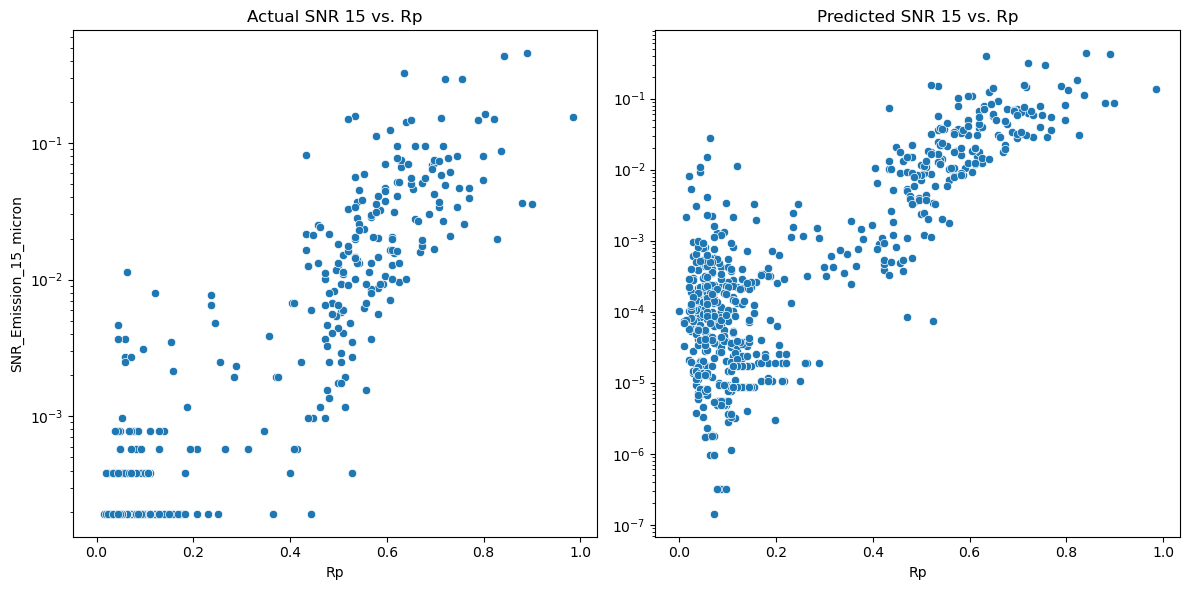

/var/folders/1q/t149zr2d73977f02zdnrf1x00000gn/T/ipykernel_23911/3155172408.py:35: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=df, x=feature_name, y=actual, palette='viridis')
/var/folders/1q/t149zr2d73977f02zdnrf1x00000gn/T/ipykernel_23911/3155172408.py:41: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=X_test[feature_name], y=predicted, palette='viridis')


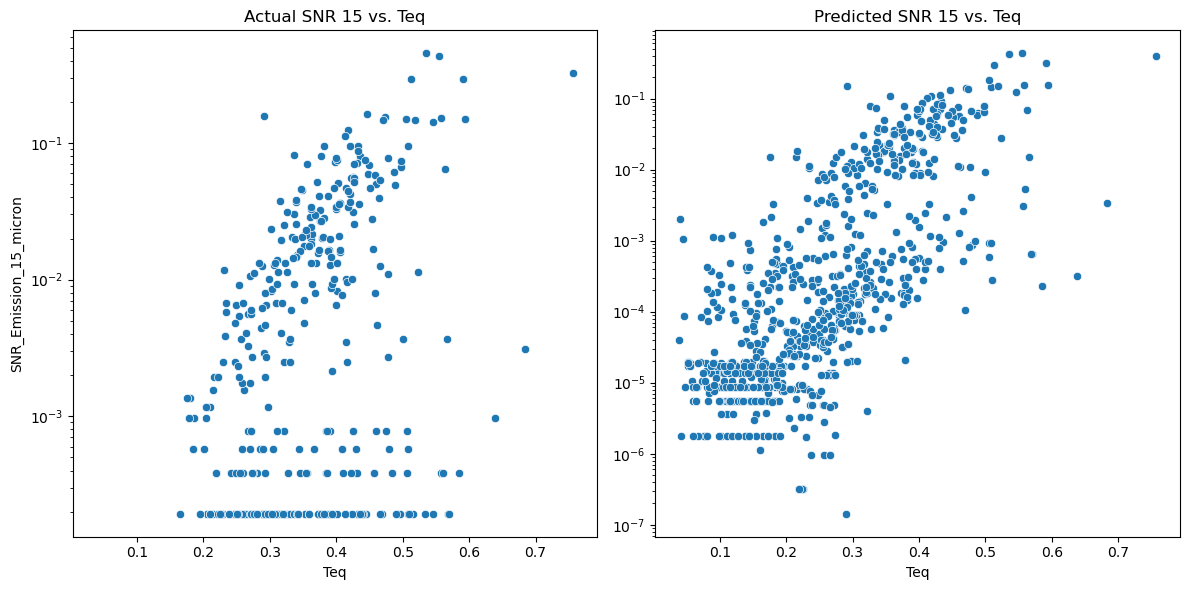

/var/folders/1q/t149zr2d73977f02zdnrf1x00000gn/T/ipykernel_23911/3155172408.py:35: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=df, x=feature_name, y=actual, palette='viridis')
/var/folders/1q/t149zr2d73977f02zdnrf1x00000gn/T/ipykernel_23911/3155172408.py:41: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=X_test[feature_name], y=predicted, palette='viridis')


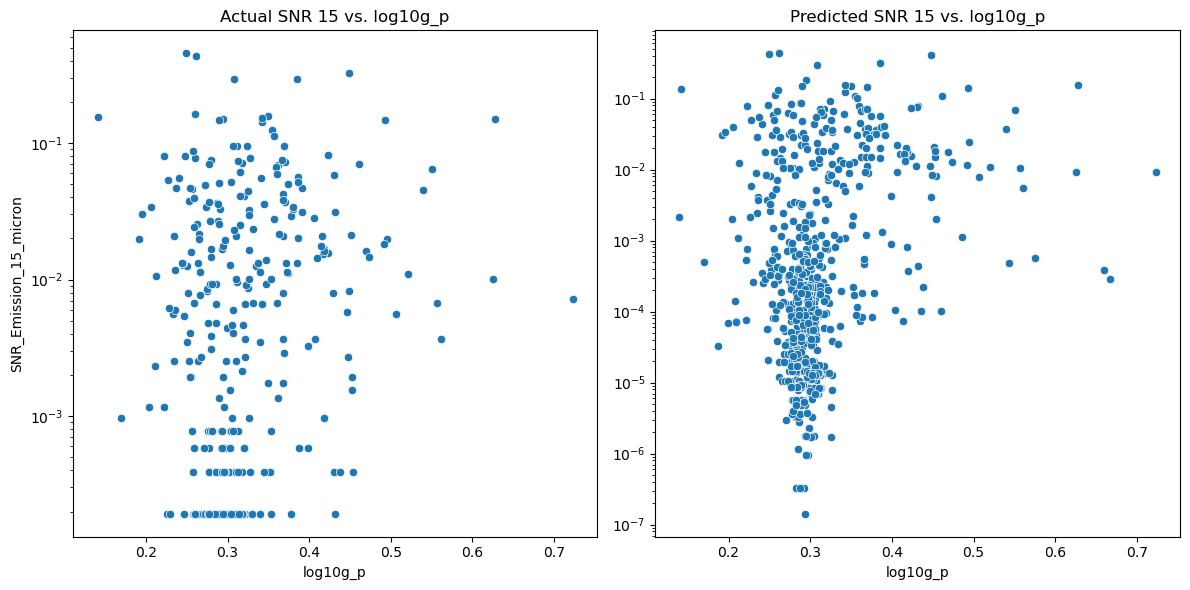

/var/folders/1q/t149zr2d73977f02zdnrf1x00000gn/T/ipykernel_23911/3155172408.py:35: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=df, x=feature_name, y=actual, palette='viridis')
/var/folders/1q/t149zr2d73977f02zdnrf1x00000gn/T/ipykernel_23911/3155172408.py:41: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=X_test[feature_name], y=predicted, palette='viridis')


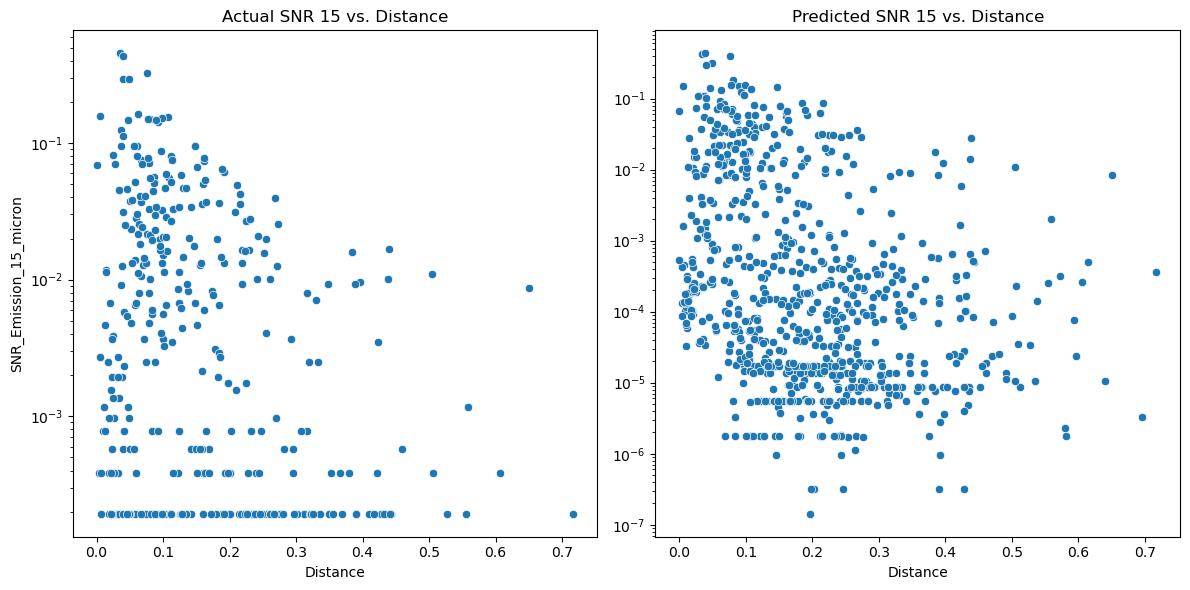

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error

# Function for model evaluation
def evaluate_model(model, X_train, X_test, y_train, y_test):
    """_summary_

    Args:
        model (_type_): _description_
        X_train (_type_): _description_
        X_test (_type_): _description_
        y_train (_type_): _description_
        y_test (_type_): _description_

    Returns:
        _type_: _description_
    """
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    mae_train = mean_absolute_error(y_train, y_train_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)
    return mae_train, mae_test, y_test_pred

# Function for hyperparameter tuning
def tune_hyperparameters(model, param_grid, X_train, y_train):
    """_summary_

    Args:
        model (_type_): _description_
        param_grid (_type_): _description_
        X_train (_type_): _description_
        y_train (_type_): _description_

    Returns:
        _type_: _description_
    """
    grid_search = GridSearchCV(model, param_grid, cv=5)
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_
    return best_params

# Function for cross-validated evaluation
def cross_validate_model(model, X, y):
    """_summary_

    Args:
        model (_type_): _description_
        X (_type_): _description_
        y (_type_): _description_

    Returns:
        _type_: _description_
    """
    mae_scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=5)
    return -mae_scores  # Negate the scores to obtain positive MAE values

# Function to plot the results
def plot_results(actual, predicted, feature_name):
    """_summary_

    Args:
        actual (_type_): _description_
        predicted (_type_): _description_
        feature_name (_type_): _description_
    """
    plt.figure(figsize=(12, 6))
    
    # Actual SNR 15 vs. Feature
    plt.subplot(1, 2, 1)
    sns.scatterplot(data=df, x=feature_name, y=actual, palette='viridis')
    plt.yscale('log')
    plt.title(f'Actual SNR 15 vs. {feature_name}')

    # Predicted SNR 15 vs. Feature
    plt.subplot(1, 2, 2)
    sns.scatterplot(x=X_test[feature_name], y=predicted, palette='viridis')
    plt.yscale('log')
    plt.title(f'Predicted SNR 15 vs. {feature_name}')

    plt.tight_layout()
    plt.show()

# 1a. Supervised Learning (Gradient Boosting Regression)
# Define features (X) and target variable (y)
features = ['Rp', 'Mp', 'Tday', 'Teq', 'log10g_p', 'Period', 'Transit_Duration', 'K_mag', 'Distance', 'Teff', 'log10g_s']
target = 'SNR_Emission_15_micron'

X = df[features]
y = df[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Gradient Boosting Regressor
gb_regressor = GradientBoostingRegressor(n_estimators=200, random_state=0)

# Hyperparameter tuning for regularization
param_grid = {
    'alpha': [0.1, 0.5, 0.9],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2]
}

# Tune hyperparameters
best_params = tune_hyperparameters(GradientBoostingRegressor(n_estimators=200, random_state=0), param_grid, X_train, y_train)
print("Best Parameters:", best_params)

# Fit the model with the best parameters
best_gb_regressor = GradientBoostingRegressor(n_estimators=200, random_state=0, **best_params)
best_gb_regressor.fit(X_train, y_train)
y_train_pred_best = best_gb_regressor.predict(X_train)
y_test_pred_best = best_gb_regressor.predict(X_test)

# Cross-validated evaluation
mae_scores_cv = cross_validate_model(best_gb_regressor, X, y)

# Print mean MAE scores across folds
print("Cross-validated Mean MAE:", mae_scores_cv.mean())

# Print MAE for training and testing sets
mae_train, mae_test, _ = evaluate_model(best_gb_regressor, X_train, X_test, y_train, y_test)
print(f"MAE on Training Set: {mae_train:.2f}")
print(f"MAE on Testing Set: {mae_test:.2f}")

# Scatter plot of predicted SNR values vs. actual SNR values
plot_results(y_test, y_test_pred_best, 'Rp')
plot_results(y_test, y_test_pred_best, 'Teq')
plot_results(y_test, y_test_pred_best, 'log10g_p')
plot_results(y_test, y_test_pred_best, 'Distance')


<h4>Results of Gradient-Boosting Regression</h4>

The Mean Absolute Error for Gradient-Boosting on both the training and testing sets being 0 raises concerns about overfitting. This suggests that the model may be too accurate to the training data, resulting in exceptional predictive accuracy but potentially limited generalizability to unseen data. The incorporation of cross-validation provides a more nuanced understanding of the model's performance, indicating areas for improvement and ensuring a more robust evaluation.

The Cross-Validated Mean MAE is also calculated, taking into account the average MAE across different folds. It comes out to Cross-validated Mean MAE: 0.0019066009974601944. This is a very low number, suggesting that the model has good accuracy.

The above plots all depict the actual test values vs the predicted values estimated by the Gradient-Boosting Regressor for SNR vs. Planet Radius, Equilibrium Temperature, Planet Gravity, and Planet-Star Distance. All plots reflect similarities between correlations and trends within actual and predicted models, suggesting that the Gradient-Boosting Regressor is quite accurate.




<h2>Unsupervised Learning</h3>
Unsupervised models can be applied here to cluster data, perform dimensionality reduction, and better understand the local relationships between data points.

<h3>K-Means Clustering</h2>

K-Means Clustering is an unsupervised machine method used to cluster data into distinct groups (clusters) based on similarity. The goal of K-Means is to partition a dataset into K clusters, where each data point belongs to the cluster with the nearest mean (centroid).

Although the machine learning problem I'm looking to solve deals more with unsupervised learning, we can still apply clustering to see how exoplanets might be categorized based on their levels of observability.

In implementing K-means, a pipeline is established which takes the preprocessed data and

1. Feature Selection: to analyze the relationship between 1.5 Micron Emission SNR, 5 Micron Emission SNR, and Planet Radius, these 3 features are chosen. Adding more features would result in a lower silhouette score.
2. Imputes the data using a SimpleImputer()
3. Scales the data using a StandardScaler()
4. Applies the K-Means model
5. Performs Hyperparameter Tuning using GridSearchCV

Hyperparameters considered (& Best Parameters):
- `n_clusters`: number of clusters to form (# of centroids to generate)
- `init`: method for initializing centroids (k-means++)
- `max_iter`: maximum # of iterations for the KMeans algorithm for a single run (200)
- `n_init`: number of times KMeans algorithm will be run with different centroid seeds.
    
6. Evaluates & Visualizes




Best Parameters: {'kmeans__init': 'k-means++', 'kmeans__max_iter': 200, 'kmeans__n_clusters': 4, 'kmeans__n_init': 10}

Cluster 0:
        Planet_Name  SNR_Emission_15_micron  SNR_Emission_5_micron  \
23         55 Cnc e                0.066280               0.080311   
68       CoRoT-22 b                0.000193               0.002591   
95        CoRoT-7 b                0.001932               0.002591   
96        CoRoT-8 b                0.000193               0.007124   
109       GJ 1214 b                0.000000               0.014896   
...             ...                     ...                    ...   
18359    TOI-4600 b                0.000000               0.000648   
18360    TOI-5126 c                0.000193               0.003886   
18423     TOI-332 b                0.007923               0.011010   
18424  HIP 113103 b                0.000000               0.002591   
18427    TOI-1853 b                0.003865               0.009715   

       SNR_Transmission_K_ma

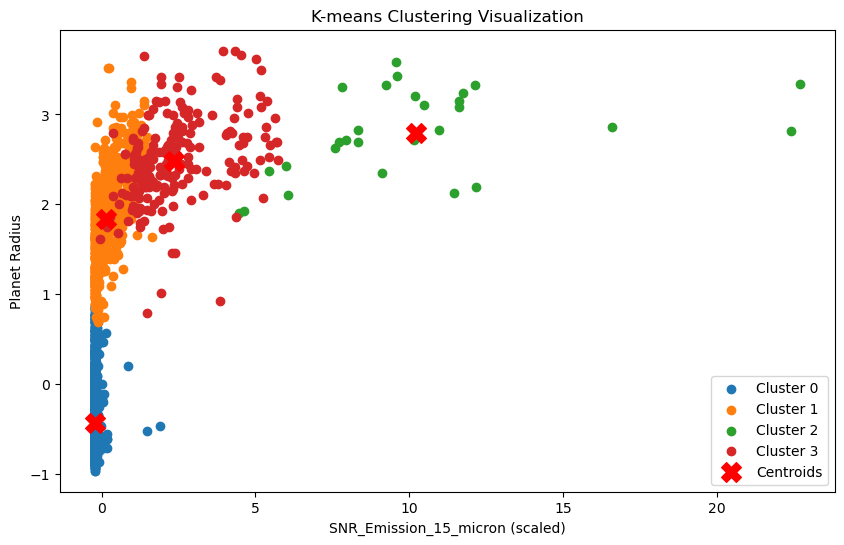

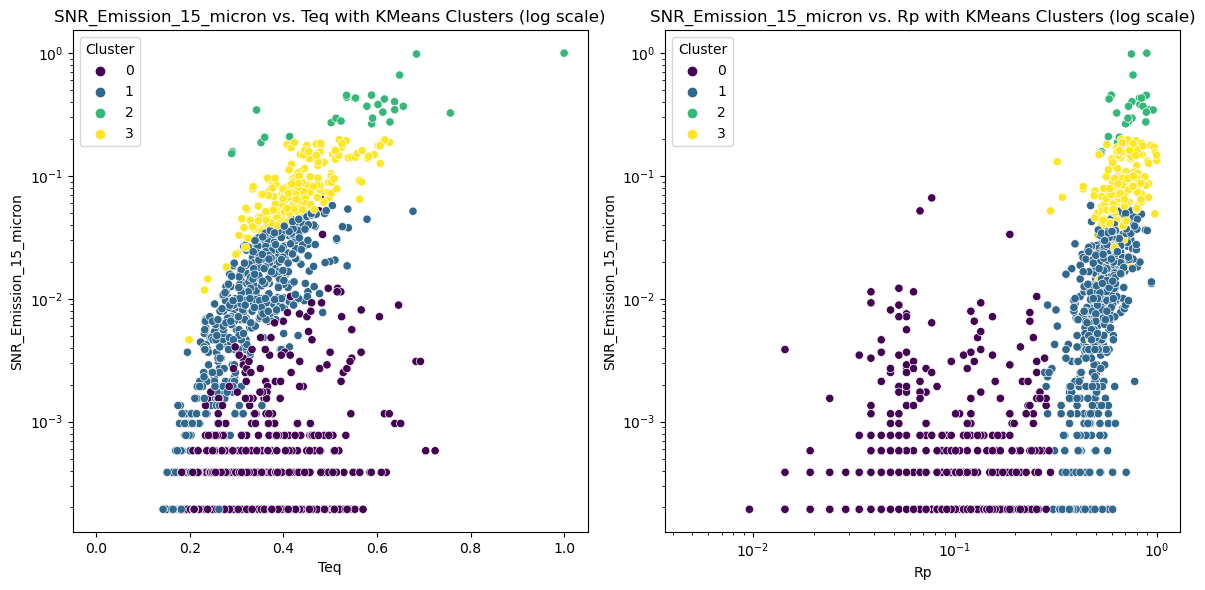

In [52]:
# 2. Unsupervised Learning (K-means Clustering)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score


# Features for clustering
X_cluster = df[['SNR_Emission_15_micron', 'SNR_Emission_5_micron', 'Rp']]

# Apply log transformation to the features
X_cluster_log = np.log1p(X_cluster)

# Impute missing values
imputer = SimpleImputer(strategy='mean')  
X_cluster_log_imputed = imputer.fit_transform(X_cluster_log)

# Standardize the features
scaler = StandardScaler()
X_cluster_scaled = scaler.fit_transform(X_cluster_log_imputed)

# KMeans pipeline
kmeans_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('kmeans', KMeans())
])

# Hyperparameter grid for KMeans
param_grid = {
    'kmeans__n_clusters': [1,2,3,4],
    'kmeans__init': ['k-means++', 'random'],
    'kmeans__max_iter': [100, 200, 300],
    'kmeans__n_init': [10]
}
# GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(kmeans_pipeline, param_grid, cv=5)
grid_search.fit(X_cluster_scaled)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Fit the pipeline with the best parameters
best_kmeans_pipeline = grid_search.best_estimator_

# Predict clusters
df['Cluster'] = best_kmeans_pipeline.named_steps['kmeans'].predict(X_cluster_scaled)

# Explore the resulting clusters
for cluster_label in range(best_params['kmeans__n_clusters']):
    print(f'\nCluster {cluster_label}:')
    print(df[df['Cluster'] == cluster_label])

# Evaluate the silhouette score
silhouette_score_kmeans = silhouette_score(X_cluster_scaled, df['Cluster'])
print(f"Silhouette Score on KMeans Clusters: {silhouette_score_kmeans}")

# Scatter plot of clustered data
plt.figure(figsize=(10, 6))

for cluster_label in range(best_params['kmeans__n_clusters']):
    cluster_data = X_cluster_scaled[df['Cluster'] == cluster_label]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 2], label=f'Cluster {cluster_label}')

# Plot centroids
centroids = best_kmeans_pipeline.named_steps['kmeans'].cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 2], marker='X', s=200, c='red', label='Centroids')

plt.title('K-means Clustering Visualization')
plt.xlabel('SNR_Emission_15_micron (scaled)')
plt.ylabel('Planet Radius')
plt.legend()
plt.show()

# Scatter plot of SNR_Emission_15_micron vs. Teq with color-coded KMeans clusters
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(data=df, x='Teq', y='SNR_Emission_15_micron', hue='Cluster', palette='viridis')
plt.yscale('log')
plt.title('SNR_Emission_15_micron vs. Teq with KMeans Clusters (log scale)')

# Scatter plot of SNR_Emission_15_micron vs. Rp with color-coded KMeans clusters
plt.subplot(1, 2, 2)
sns.scatterplot(data=df, x='Rp', y='SNR_Emission_15_micron', hue='Cluster', palette='viridis')
plt.yscale('log')
plt.xscale('log')
plt.title('SNR_Emission_15_micron vs. Rp with KMeans Clusters (log scale)')

plt.tight_layout()
plt.show()




<h4>Results of K-Means Clustering</h4>

Accuracy:
The Silhouette Score on the Kmeans clusters is 0.79108227983781. This score measures how well defined each cluster is and accounts for things such as overlap. The received score suggests that data points are mostly well-matched to their own respective clusters and not matched as well to neighboring clusters, but there are exceptions. Soem overlap between clusters is still likely and so this method doesn't perform best.

This suggests that the relationship between SNR values and Planet Radius (Rp) can help efficiently categorize exoplanets based on atmosphere observability if so desired.

However, adding more features to the K-Means algorithm such as Distance and Equilibrium Temperature (not implemented in this report) reduced the silhouette score significantly and resulted in much more overlap. This is due to high dimensionality in the model.

Plot Results:
The first plot above shows the K=means clustering between 1.5 Micron SNR Emission and Planet Radius.
This plot shows some evident overlap between clusters, and overall poor performance. The 'X' points denote the cluster centroids, which are far apart and reflect good clustering.

The second set of plots above show the K-means clusters as hues for plots for 15 Micron SNR Emission vs. Equilibrium Teperature and vs. Planet Radius. Although there is decent clustering,the plots show that there is some overlap between clusters, so this method is not perfect. Clusters are very close together and there isn't a strict distinction between them. Kmeans clustering may not be the best method for the purposes of this dataset.

<h3>Principal Component Analysis</h3>

Principal Component Analysis (PCA) is a dimensionality reduction technique for machine learning. It's primary goal is to transform the original features of a dataset into a new set of uncorrelated features (principal components), which capture the maximum variance in the data.

We can apply PCA to our data to perform dimensionality reduction and to visualize the high-dimensional data as it is projected onto a lower-dimensional space.

In implementing PCA, a pipeline is established which takes the preprocessed data and

1. Imputes the data using a SimpleImputer()
2. Scales the data using a StandardScaler()
3. Applies PCA()
4. Performs Hyperparameter Tuning using GridSearchCV

Hyperparameters considered (& Best Parameters):
- `n_components`: number of principal components to retain during PCA (3)
- `svd_solver': algorithms for singular value decomposition (SVD) (randomized)
- `iterated_power`: specified number of iterations for the power method used in randomized SVD solver

    
5. Evaluates & Visualizes



/Users/anupammishra/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
75 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/anupammishra/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 730, in _fit_and_score
    estimator.fit(X_train, **fit_params)
  File "/Users/anupammishra/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/anupammishra/anaconda3/lib/python3.11/site-packages/sklearn/pipe

Best Parameters for PCA: {'pca__iterated_power': 5, 'pca__n_components': 2, 'pca__svd_solver': 'full'}
Principal Components:
        PC1       PC2
0  0.581453  0.551931
1  0.619186  0.176373
2  0.527751 -0.815024
Explained Variance Ratio: [0.79860487 0.16371345]


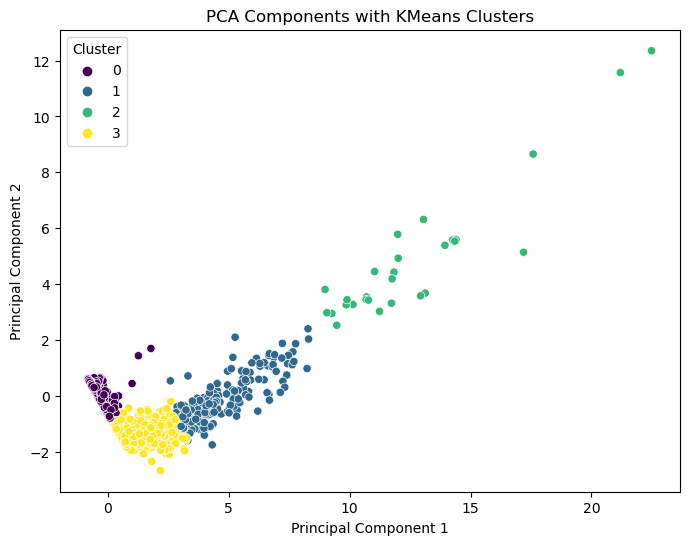

In [21]:
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming X_cluster_log_imputed is defined

# PCA pipeline
pca_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('pca', PCA())
])

# Hyperparameter grid for PCA
param_grid_pca = {
    'pca__n_components': [2, 3, 4],
    'pca__svd_solver': ['auto', 'full', 'arpack', 'randomized'],  # Add solver options
    'pca__iterated_power': [5, 10, 15]  # Adjust iterated_power
}


# GridSearchCV for hyperparameter tuning
grid_search_pca = GridSearchCV(pca_pipeline, param_grid_pca, cv=5)
grid_search_pca.fit(X_cluster_log_imputed)

# Get the best parameters
best_params_pca = grid_search_pca.best_params_
print("Best Parameters for PCA:", best_params_pca)

# Fit and transform the data using PCA with the best parameters
X_pca = grid_search_pca.best_estimator_.transform(X_cluster_log_imputed)

# Access the principal components
principal_components = grid_search_pca.best_estimator_['pca'].components_

# Create a DataFrame to display the results
components_df = pd.DataFrame(principal_components.T, columns=[f'PC{i+1}' for i in range(principal_components.shape[0])])
print("Principal Components:")
print(components_df)

# Visualize the explained variance ratio
explained_variance = grid_search_pca.best_estimator_['pca'].explained_variance_ratio_
print("Explained Variance Ratio:", explained_variance)

pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])
# Add the 'Cluster' column to the PCA DataFrame
pca_df['Cluster'] = df['Cluster']

# Scatter plot of PCA components
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df['Cluster'], palette='viridis')
plt.title('PCA Components with KMeans Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


<h4>Results of Principal Component Analysis (PCA)</h4>

The Explained Variance Ratio is [0.79860487 0.16371345 0.03768169]. This ratios show how much of the variance is accounted for in each principal component, of which there are 3. Since PCA always generates a vector in the direction of maximum variance and projects data onto that axis, the first principal component has the highest variance ratio, with the second having the second most and the third one having the least. 

This basically helps us with reducing dimensionality. The PCA model has done a good job of doing so.

75 of the 180 fits fail during the hyperparameter tuning. More fine tuning may be required to deal with this issue.

Plot Results: These results can also be depicted by the PCA plot below, which has a well-defined first principal axis with a shorter second principal axis. Most of the data lies on or close to a single axis (principal axis with maximum variance), with some data branching off onto a second axis. Therefore, the data has strong variance along two different axes.

<h3>Manifold Learning - t-Stochastic Nearest Neighbor Embeddings (t-SNE)</h3>

t-SNE is another dimensionality reduction technique for visualizing high-dimensional data in a lower-dimensional space. It's good to use for non-linear relationships within the data, so it is suitable for the exoplanet dataset. As a manifold learning tachnique, t-SNE can preserve the local relationships between data points while reducing the overall dimensionality of the data.

For t-SNE, a pipeline is established which takes the preprocessed data and

1. Imputes the data using a SimpleImputer()
2. Scales the data using a StandardScaler()
3. Applies TSNE()
4. Performs Hyperparameter Tuning using GridSearchCV

Hyperparameters considered (& Best Parameters):
- `n_components`: number of components in the low-dimensional representation (2)
- `perplexity`: balances attention between local and global aspects of data (30)
- `learning_rate`: controls the step size in the optimization process and can impact the convergence and quality of the low-dimensional representation (10)

    
5. Evaluates & Visualizes

The t-SNE method is visualized in the plot below. It offers a visualization of the relationships between the data, and the hue is based on the clusters from the K-means clustering.

/Users/anupammishra/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/anupammishra/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 811, in _score
    scores = scorer(estimator, X_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/Users/anupammishra/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/anupammishra/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 811, in _score
    scores = scorer(estimator, X_test)
            

Best Parameters for t-SNE: {'tsne__learning_rate': 10, 'tsne__n_components': 2, 'tsne__perplexity': 30}


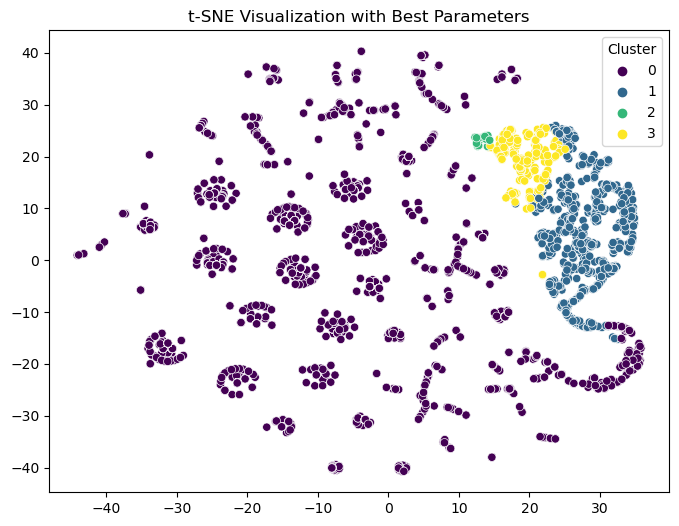

In [53]:
# Manifold Learning

# Import t-SNE
from sklearn.manifold import TSNE
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming X_cluster_log_imputed is defined

# t-SNE pipeline
tsne_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('tsne', TSNE())
])

# Hyperparameter grid for t-SNE
param_grid_tsne = {
    'tsne__n_components': [2],  # Adjust the number of components as needed
    'tsne__perplexity': [30, 50, 100],
    'tsne__learning_rate': [10, 50, 100]
}

# Specify scoring metric
scoring_metric = make_scorer(mean_squared_error, greater_is_better=False)

# GridSearchCV for hyperparameter tuning
grid_search_tsne = GridSearchCV(tsne_pipeline, param_grid_tsne, cv=5, scoring=scoring_metric)
grid_search_tsne.fit(X_cluster_log_imputed)

# Get the best parameters
best_params_tsne = grid_search_tsne.best_params_
print("Best Parameters for t-SNE:", best_params_tsne)

# Fit and transform the data using t-SNE with the best parameters
X_tsne = grid_search_tsne.best_estimator_['tsne'].fit_transform(X_cluster_log_imputed)

# Plot the t-SNE results
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=df['Cluster'], palette='viridis')
plt.title('t-SNE Visualization with Best Parameters')
plt.show()


<h4>Results of t-SNE</h4>

The plot above shows the local relationships within the data and provides insights into the data's structure. Data from Cluster 0 is spread out, but certain data are grouped together suggesting similarities in the high-dimensional space between them and the relationships between associated features. This may be interpreted as being reflective of the results from the PCA method, which showed that data points that fell into cluster 0 demonstrated high variance along one of the principal axes. The other clusters in the t-SNE plot are all closely grouped together. 

The t-SNE plot successfully described local relationships within the data while reducing dimensionality. However, since a lot of the data is scattered and not grouped together, it suggests that the method has flaws and changes such as fine-tuning could be made to improve it.

<h3>K-Means Clustering + PCA</h3>

Since PCA offers the ability to reduce dimensionality, I wanted to apply it to the dataset before the K-means clustering to see how it affected the clustering performance. I built the PCA and K-means pipelines and followed the same procedures as above before plotting the results. Unfortunately, the dimensionality reduction led to the data ending up in a single cluster. This is therefore not a good method for clustering.

Best Parameters: {'kmeans__init': 'k-means++', 'kmeans__max_iter': 100, 'kmeans__n_clusters': 4}


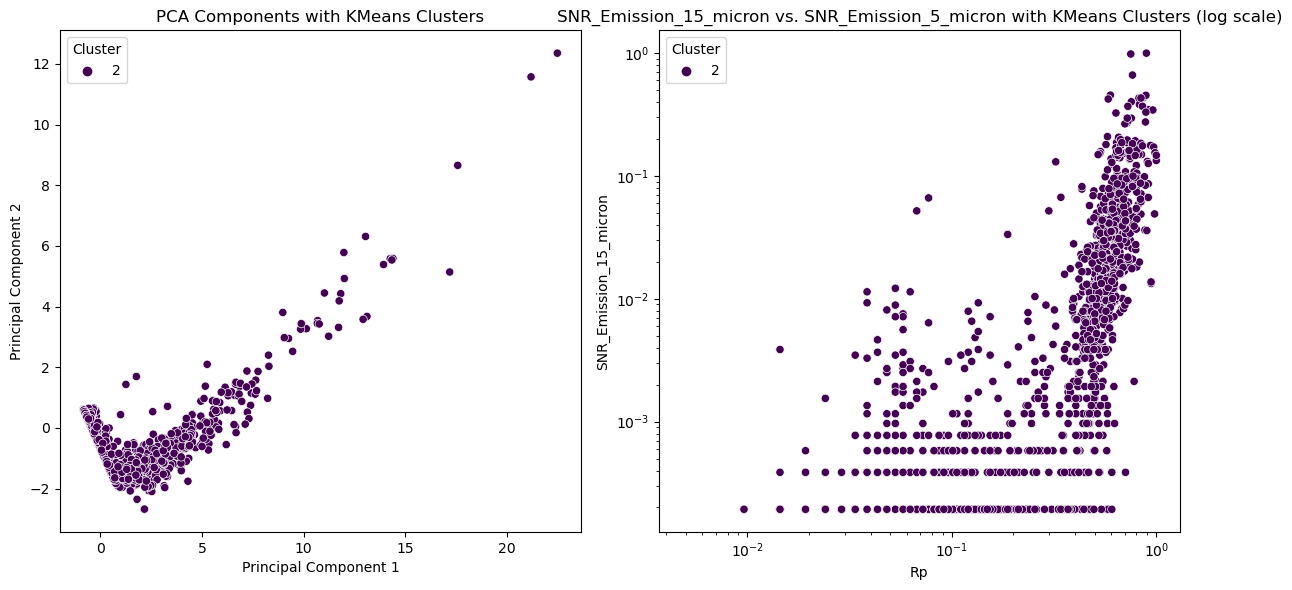

In [54]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score

# Features for clustering
X_cluster = df[['SNR_Emission_15_micron', 'SNR_Emission_5_micron', 'Rp']]

# Apply log transformation to the features
X_cluster_log = np.log1p(X_cluster)

# Impute missing values
imputer = SimpleImputer(strategy='mean')  
X_cluster_log_imputed = imputer.fit_transform(X_cluster_log)

# Standardize the features
scaler = StandardScaler()
X_cluster_scaled = scaler.fit_transform(X_cluster_log_imputed)

# PCA pipeline
pca_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=2))  # Adjust the number of components as needed
])

# Fit and transform the data using PCA
X_pca = pca_pipeline.fit_transform(X_cluster_scaled)

# KMeans pipeline
kmeans_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=3)),  # Align the number of components with PCA
    ('kmeans', KMeans(n_init=10))
])

# Hyperparameter grid for KMeans
param_grid = {
    'kmeans__n_clusters': [1, 2, 3, 4],
    'kmeans__init': ['k-means++', 'random'],
    'kmeans__max_iter': [100, 200, 300]
}

# GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(kmeans_pipeline, param_grid, cv=5)
grid_search.fit(X_cluster_log_imputed)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Fit the pipeline with the best parameters
best_kmeans_pipeline = grid_search.best_estimator_

# Predict clusters
df['Cluster'] = best_kmeans_pipeline.named_steps['kmeans'].predict(X_cluster_log_imputed)

# Scatter plot of PCA components with color-coded KMeans clusters
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df['Cluster'], palette='viridis')
plt.title('PCA Components with KMeans Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Scatter plot of 1.5 Micron Emission SNR vs. Rp with Clusters
plt.subplot(1, 2, 2)
sns.scatterplot(data=df, x='Rp', y='SNR_Emission_15_micron', hue='Cluster', palette='viridis')
plt.yscale('log') # log scale on x-axis
plt.xscale('log')# log scale on y-axis
plt.title('SNR_Emission_15_micron vs. SNR_Emission_5_micron with KMeans Clusters (log scale)')

plt.tight_layout()
plt.show()


<h4>Results of K-Means Clustering & PCA</h4>

The PCA dimensionality reduction ultimately is putting all the data under a single cluster, as shown in the plots above. This method therefore doesn't work, and so K-means clustering on its own is better for this dataset. The dimensionality reduction performed by the PCA messes with the applicability of K-means clustering on the dataset.


<h2>Conclusions</h2>

The analysis and modeling performed as part of this project reflects the importance and applicability of the exoplanet dataset used and the role that machine learning methods can play in making important predictions that can further the advent of space exploration. 

<h3>Accomplished Goals</h3>
Some of the goals that were accomplished in the project include:

1. Train supervised learning models to effectively map from features like Planet Radius to the Signal-to-Noise ratios (SNRs) with high accuracy.
2. Using unsupervised learning models to perform dimensionality reduction and clustering to better understand the nature and interrelationships within the dataset.
3. Visualizing the preprocessed data using multiple plots that describe the relationship between various features.

<h3>Future Work & Ways to Improve the Models</h3>
There are definite improvements that could be made to the machine learning models applied to the dataset. Some of these include:

1. **Exploring Feature Engineering:**
   - **Polynomial Features:** Investigating the possibility of introducing polynomial features, especially for Random Forest and Gradient Boosting Regression. Polynomial features can capture complex, non-linear relationships within the data.
   - **Feature Interaction:** Experimenting with creating new features that represent interactions between existing features. This approach might uncover valuable insights and enhance the models' ability to capture intricate patterns.
   - **Dimensionality Reduction:** Exploring feature reduction techniques, such as Recursive Feature Elimination (RFE) or feature importance analysis. This can help identify and retain the most informative features, streamlining model training.

2. **Considering Algorithmic Enhancements:**
   - **Ensemble Methods:** Exploring the potential benefits of using different ensemble methods for Random Forest and Gradient Boosting Regression. Stacking or blending multiple models could lead to synergies and improved overall performance.
   - **Fine-tuning Hyperparameters:** Conducting a more exhaustive search for hyperparameters, including the number of trees, learning rate, and other relevant parameters. Fine-tuning these values might unlock additional performance gains.
   - **Exploring Alternative Libraries:** Experimenting with alternative gradient boosting libraries like XGBoost or LightGBM. These libraries often offer optimizations that can result in faster training and enhanced model performance.

3. **Applying Data Augmentation Techniques for Clustering and Dimensionality Reduction:**
   - **t-SNE Parameter Adjustment:** In future analyses, considering adjusting the perplexity and learning rate parameters for t-SNE. Fine-tuning these parameters can significantly influence the quality of visualizations and the effectiveness of clustering.
   - **Optimizing K Means Initialization:** Experimenting with different initialization methods for K Means clustering. Finding a more suitable initialization strategy may enhance convergence and improve the quality of identified clusters.
   - **Enhancing Preprocessing:** Prioritizing effective data preprocessing before applying dimensionality reduction techniques. Ensure robust handling of missing values, and explore scaling or normalizing features to optimize the performance of clustering algorithms. (ChatGPT, 2023)

It will be crucial to systematically evaluate the impact of each strategy using appropriate evaluation metrics and cross-validation. With the aforementioned improvement methods, the learning models may have improved performance with more applicable outputs for the goals of this project.